In [1]:
# notebook dependencies
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from IPython.display import Image

# 1 Gradient Descent Via the Adjoint PDE
Let's first set the stage with some notation and a statement
of our goal (spoiler: gradient descent with a PDE constraint).

Suppose we observe noisy data $\Phi$ produced by
some phenomenon which is modeled by a PDE 
governed by parameters $\theta$.
We then pass $\Phi$ through a neural network that encodes
the data to a latent space representing $\theta$.
The final layer of this network uses the latent parameters
to obtain a solution $u$ of our PDE.
We measure model fitness with a loss functional $J$
that compares $u$ to $\Phi$.
Thus, our goal is find $\theta$ that minimizes $J$ 
where $u$ is constrained to the PDE.

This optimization procedure is performed via gradient descent.
As such, we need to compute the direction in parameter space
that points in the direction of steepest descent of $J$.
To skip the mathematical formulation skip to section 2.2.

## 1.1 The Constrained Loss Gradient

The PDE depends on two objects, $u$ and $\theta$,
so let us compactly represent it with the equation $F(u, \theta) = 0$.
For example, if the PDE is the Poisson equation
with constant force parameter $c$,

$$
    -\Delta u = c \quad \text{on} \quad \Omega = (0,1),
$$

then $F(u, c) = \Delta u + c$.
The loss functional has the same dependences, 
i.e. $J = J(u, \theta)$.
Note, however, that $F(u, \theta) = 0$ makes $u$
an implicit function of $\theta$;
solving the PDE provides a map $\theta \mapsto u_\theta$.
So we really want to minimize

$$
    \mathcal{J}(\theta) := J(u_\theta, \theta).
$$

An important observation here is that even though $\mathcal{J}$
depends only on $\theta$, _the PDE constraint is still built into 
$\mathcal{J}$ since $u$ implicitly depends on $\theta$_.
The desired gradient then becomes

$$
\boxed{
    \frac{d\mathcal{J}}{d\theta} = 
    \frac{\partial J}{\partial u}\frac{du}{d\theta}
    + \frac{\partial J}{\partial\theta}
    }
$$

We refer to this equation as the __constrained loss gradient__.
Here, $\frac{d}{d\theta}$ represents the total $\theta$ derivative,
and the partial derivative of a functional, e.g. with respect to $u$,
is defined to be the bounded linear operator $A$ such that

$$
    J(u + \varepsilon\tilde u, \theta) 
      = J(u, \theta) + A\varepsilon\tilde u + o(\varepsilon)
$$

where $\tilde u$ is an arbitrary function we use to perturb $u$.

## 1.2 The Sensitivity Equation

We use the same definition to compute partial derivatives of $F$.
For example, the $u$ partial derivative of the Poisson equation
$F(u, c) = \Delta u + c$ is 
$\frac{\partial F}{\partial u} = \Delta$, because

$$
    \Delta(u + \varepsilon\tilde u) + c - (\Delta u + c)
      = \Delta(\varepsilon\tilde u).
$$

Applying the chain rule to take the total $\theta$ 
derivative of the constraint $F(u, \theta) = 0$ yields

$$
\begin{equation}\label{opgrad}
    0 = \frac{d}{d\theta} F(u, \theta) = 
        \frac{\partial F}{\partial u} \frac{du}{d\theta} + \frac{\partial F}{\partial \theta}.
\end{equation}
$$

or, equivalently,

$$
\boxed{
    \frac{\partial F}{\partial\theta} 
      = - \frac{\partial F}{\partial u} \frac{du}{d\theta}
}
$$

We refer to this as the __sensitivity equation__.

## 1.3 The Lagrangian
Clearly the loss functional and the PDE that constrains 
it are intimately linked. 
The Lagrangian unifies $J$ and $F$ in a single equation.
For any $\lambda$ that is dual to $u$, 
define the __Lagrangian functional__ $\mathcal{L}$ by 

$$
\boxed{
    \mathcal{L}(u, \theta, \lambda) = 
        J(u, \theta) - \lambda^* F(u, \theta)
        }
$$

Note that since $\lambda$ is dual to $u$, 
$\lambda^* F$ properly defines a functional.
For example, when $F(u, \theta=c) = \Delta u + c$ 
as in the Poisson equation,

$$
    \lambda^* F(u, c) = \int_\Omega\! \lambda(\Delta u + c)\,dx
$$

## 1.4 The Adjoint Equation
Notice the PDE constraint is recovered by setting the
$\lambda$ derivative of $\mathcal{L}$ equal to zero, i.e.

$$
    \frac{\partial\mathcal{L}}{\partial\lambda} = 0
    \quad \iff \quad
    F(u, \theta) = 0
$$

The constraint $F = 0$ is sometimes called the _state equation_. Consequently, we obtain the _co-state equation_
by setting the $u$ derivative of the Lagrangian equal to zero, i.e.

$$
    \frac{\partial\mathcal{L}}{\partial u}^* = 0
    \quad \iff \quad \boxed{
    \frac{\partial J}{\partial u}^* 
        - \frac{\partial F}{\partial u}^* \lambda = 0
        }
$$

We will refer to the above co-state equation as the __adjoint equation__.

## 1.5 Putting it all together
Keeping our eye on the prize, recall we wish to compute
the right hand side of the constrained loss gradient equation.
Once we choose a loss functional $J$, it is generally straightforward
to compute $\frac{\partial J}{\partial\theta}$ 
and $\frac{\partial J}{\partial u}$, 
but without an analytic solution to $F(u, \theta) = 0$ 
the term $\frac{du}{d\theta}$ is intractable.
What's more, if $u$ is stored as a large array and we have
many parameters then $\frac{du}{d\theta}$ will be a large dense matrix.
Thus, to obtain the constrained loss gradient
we need a way to indirectly compute $\frac{du}{d\theta}$.

To do this, we substitue the adjoint equation into 
the constrained loss gradient equation, 
then substitue the sensitivity equation into that.
Explicitly,

$$
\begin{align*}
    \frac{d\mathcal{J}}{d\theta}
      &= \frac{\partial J}{\partial u}\frac{du}{d\theta}
        + \frac{\partial J}{\partial\theta}
        & &\text{constrained loss gradient}\\
      &= \lambda^*\frac{\partial F}{\partial u}\frac{du}{d\theta}
        + \frac{\partial J}{\partial\theta}
        & &\text{substitute adjoint equation}\\
      &= -\lambda^*\frac{\partial F}{\partial\theta} 
        + \frac{\partial J}{\partial\theta}
        & &\text{substitute sensitivity equation}
\end{align*}
$$

The above calculation gives rise to the following general algorithm
(see diagram below):

1. Compute $\frac{\partial J}{\partial u}$ and $\frac{\partial F}{\partial u}$ to formulate the adjoint equation.
2. Solve the adjoint equation $\frac{\partial F}{\partial u}^*\lambda = \frac{\partial J}{\partial u}^*$ for $\lambda$.
3. Compute $\frac{\partial J}{\partial\theta}$ and $\frac{\partial F}{\partial\theta}$ to obtain the constrained loss gradient
$\frac{d\mathcal{J}}{d\theta} = -\lambda^* \frac{\partial F}{\partial\theta} + \frac{\partial J}{\partial\theta}$



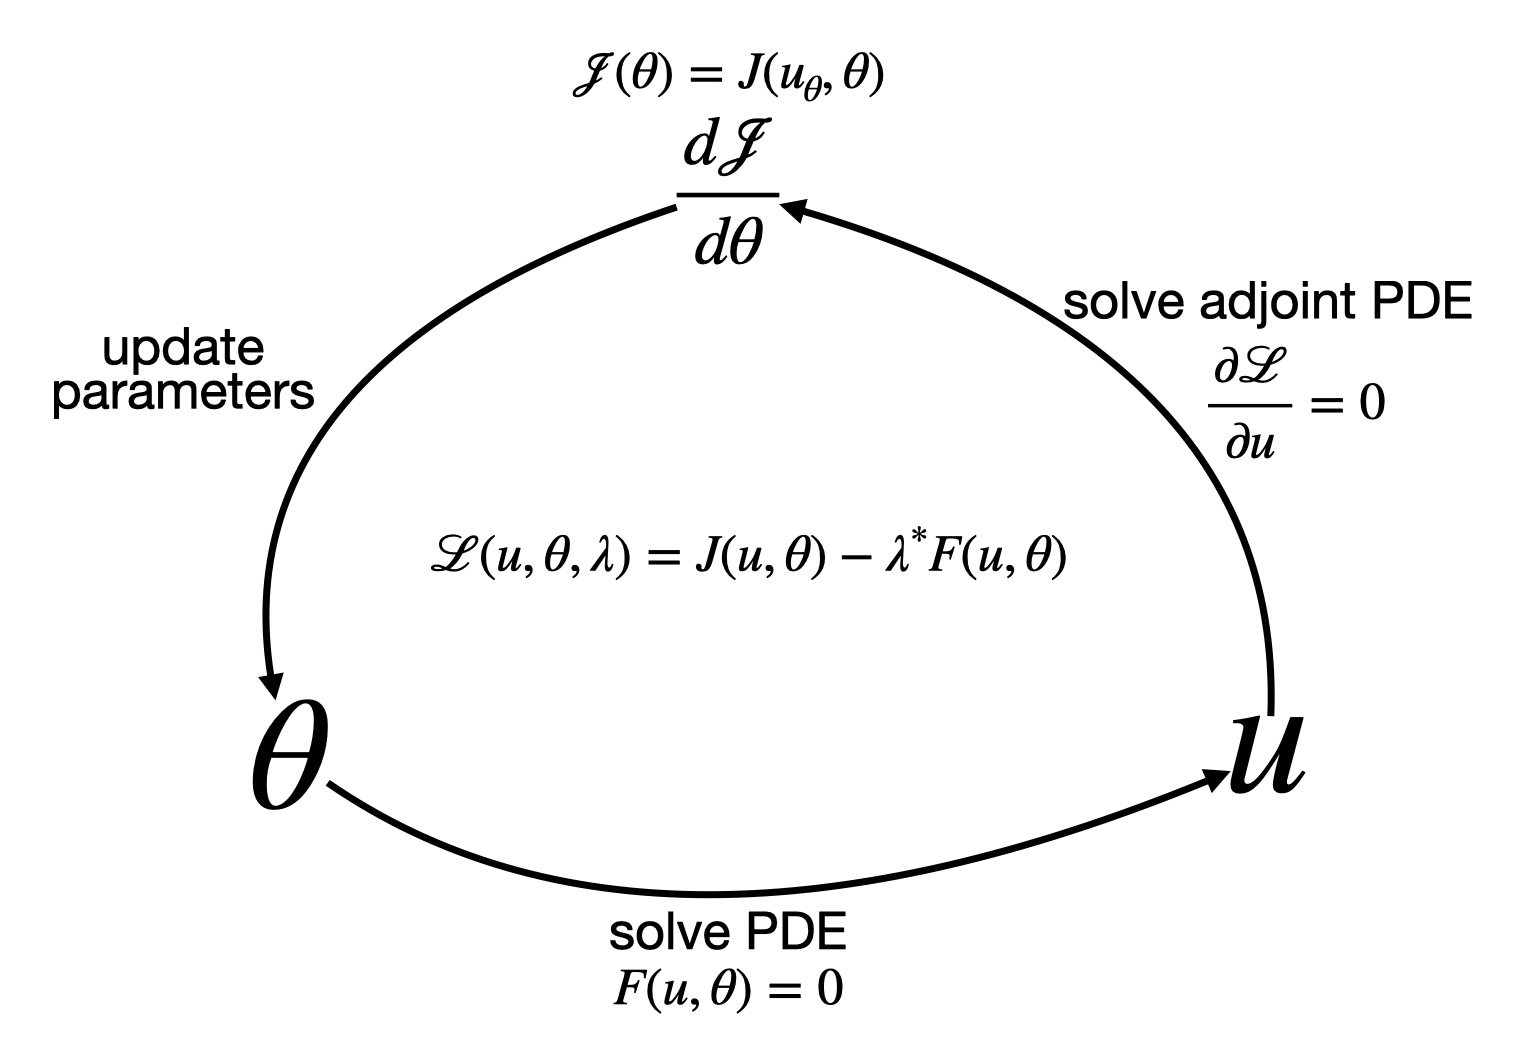

In [2]:
Image('descent_diagram.png', width=750)

Of course, the end goal of this procedure is to assist the gradient
descent with a neural network that encodes $\Phi \to \theta$,
as in the following diagram.

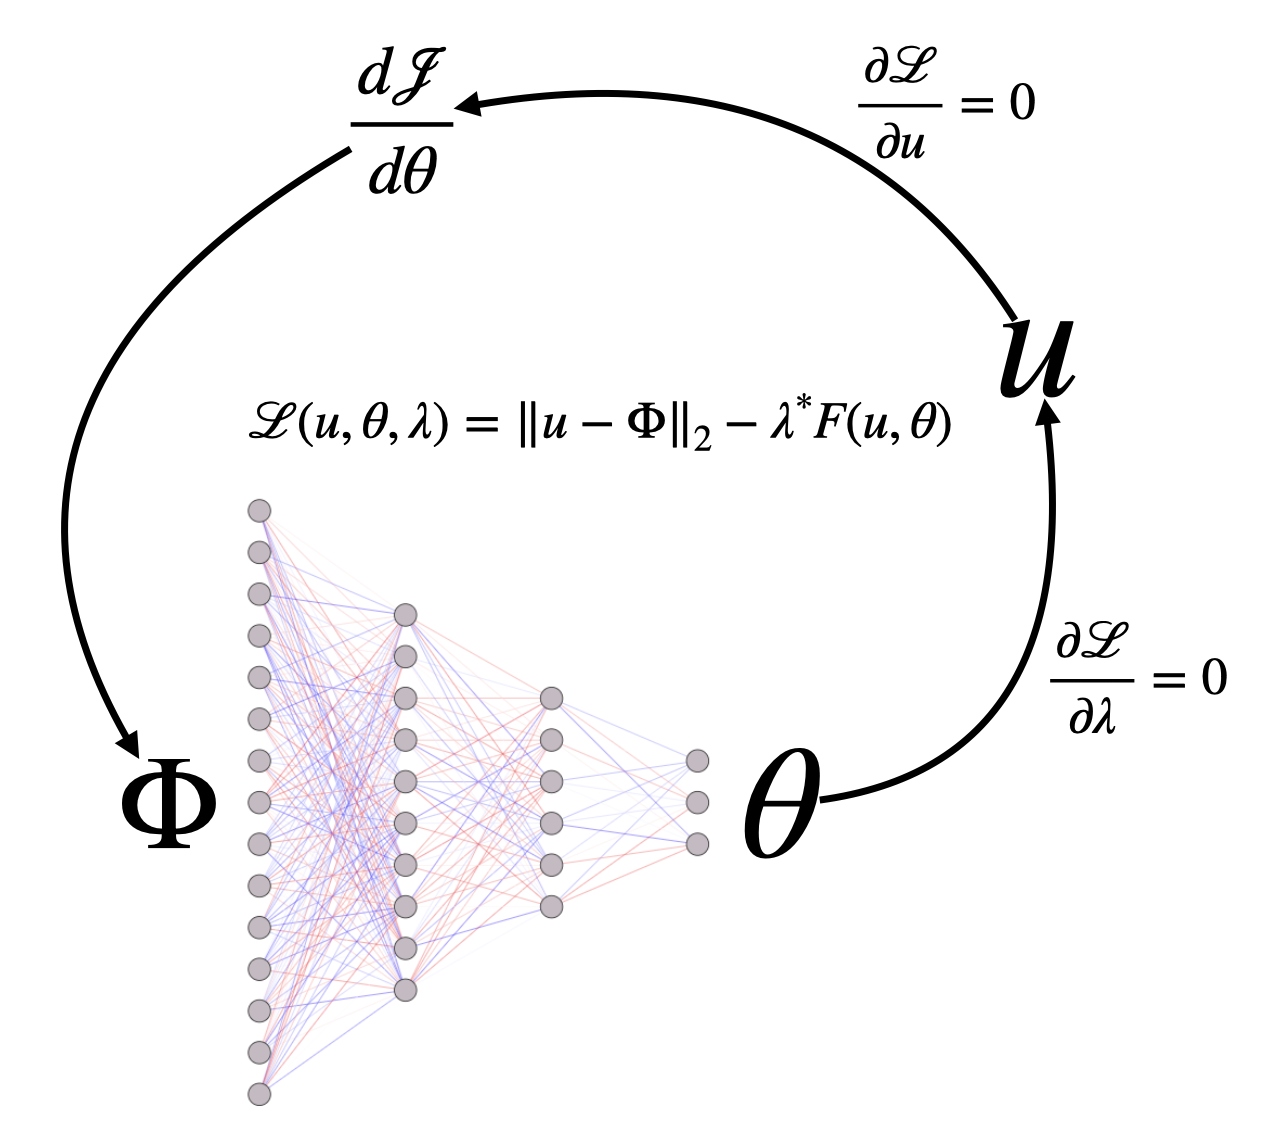

In [3]:
Image('neural_assisted_descent.png', width=750)

# 2 The constant force Poisson equation

Let's return to the Poisson equation on the unit interval:

$$
\begin{align*}
    -\Delta u &= c \quad \text{on} \quad \Omega = (0,1) \\
    u &= b \quad \text{on} \quad \partial\Omega
\end{align*}
$$

where $\theta = c$ is a constant force parameter,
$b$ is given, and $\partial\Omega = \{0, 1\}$ is the domain boundary.
For brevity, denote $b(x) = b_x$ for $x$ on the boundary.
Given observations $\Phi$ we define $J$ to be the $L^2$ loss

$$
    J(u, c) = \frac{1}{2} \int_\Omega\! (u - \Phi)^2\, dx
$$

## 2.1 Analytic Calculations
The analytic solution,
which can be seen as an explicit function of $c$, is 

$$
    u(x) = -\frac{c}{2} x^2 
        + \left( \frac{c}{2} + b_1 - b_0 \right) x 
        + b_0.
$$

Suppose our observed data $\Phi$ depends on 
some fixed true parameter $\kappa$ so that

$$
\Phi(x)
     = -\frac{\kappa}{2} x^2 
        + \left( \frac{\kappa}{2} + b_1 - b_0 \right) x 
        + b_0
$$

### 2.1.1 Computing the Gradient Directly
Since we have an analytic solution,
we can compute the loss gradient directly.
We would like to see how the loss functional 
$\mathcal{J}(c) = \frac{1}{2}\| u - \Phi \|_2^2$ 
varies with $c$.
First note $\mathcal{J}$ does not explicitly depend on $c$,
hence $\frac{\partial J}{\partial c} = 0$.
So we easily compute

$$\boxed{
    \frac{d\mathcal{J}}{dc} 
        = \int_\Omega \! (u - \Phi)\frac{du}{dc}\, dx
        = \frac{c - \kappa}{120}.
}$$

### 2.1.2 Adjoint Poisson Equation
Here we use the Lagrangian to derive an adjoint PDE
associated with the Poisson equation.
More specifically, the adjoint PDE is obtained by 
solving $\frac{\partial\mathcal{L}}{\partial u} = 0$.
Let's step through the general algorith outlined in the previous section.

__Step 1:__ First, it is easy to see $\frac{\partial F}{\partial c} = 1$.
The loss derivative is just as straightforward:

$$
    \frac{\partial J}{\partial u} 
        =  \int_\Omega\!dx \,(u - \Phi)
$$

Now we identify $F(u, c) = \Delta u + c$
and immediately see $\frac{\partial F}{\partial u} = \Delta$.

__Step 2:__ From the above calculations we immediately obtain

$$
    \frac{\partial\mathcal{L}}{\partial u}
      = \int_\Omega\!dx \,(u - \Phi) - \int_\Omega\!dx\, \lambda\Delta
$$

To formulate the adjoint equation we must calculate the adjoint
of the above operator.
To that end, consider how $\frac{\partial\mathcal{L}}{\partial u}$
operates on some test function $\tilde u$,

$$
    \frac{\partial\mathcal{L}}{\partial u}(\tilde u) 
     = \int_\Omega\!(u - \Phi)\tilde u\, dx
     - \int_\Omega\! \lambda \Delta\tilde u\, dx
$$

Notice the first integral is self-adjoint, i.e.
$\int v(u - \Phi)\tilde u\, dx = \int \tilde u (u - \Phi)v\, dx$
for any function $v$.
To compute the adjoint of the second integral
we must strip away the Laplacian from our test function.
Indeed, we integrate by parts twice, which gives the 
left hand side of the adjoint equation
$\frac{\partial\mathcal{L}}{\partial u}^* = 0$.

$$
\begin{align*}
  \frac{\partial\mathcal{L}}{\partial u}^*(\lambda) 
    = \int_\Omega\!\tilde u(u - \Phi)\, dx
     - \int_{\partial\Omega}\!\frac{\partial\tilde u}{\partial n}\lambda
     + \int_{\partial\Omega}\!\tilde u\frac{\partial\lambda}{\partial n}
     - \int_\Omega\! \tilde u\Delta\lambda\, dx 
\end{align*}
$$

Here, $\frac{\partial}{\partial n}$ is the derivative
in the direction of the outward unit normal vector $n$ 
on $\partial\Omega$, so $n=-1$ at $x=0$ and $n=1$ at $x=1$.
Collecting like terms and setting equal to zero, we have

$$
  \int_\Omega\!\tilde u(u - \Phi - \Delta\lambda)\, dx
     - \int_{\partial\Omega}\!\frac{\partial\tilde u}{\partial n}\lambda
     + \int_{\partial\Omega}\!\tilde u\frac{\partial\lambda}{\partial n}
   = 0
$$

We seek a solution to the above equation for arbitrary $\tilde u$,
so let $\tilde u$ vanish on the boundary and 
set each of the remaining integrands equal to zero. 
This implies $\lambda$ must be the solution to the following __adjoint Poisson equation__:

$$
\begin{align*}
    \Delta\lambda &= u - \Phi & &\text{on } \Omega = (0,1) \\
    \lambda &= 0 & &\text{on } \partial\Omega \\
\end{align*}
$$

Using the analytic solution of $u$, the equation on $\Omega$ becomes

$$
    \Delta\lambda = \frac{c - \kappa}{2}(x - x^2),
$$

or, for constants of integration $C_1$ and $C_2$,

$$
\begin{align*}
    \lambda(x) = \frac{c - \kappa}{2} \left(\frac{x^3}{6} - \frac{x^4}{12} + C_1x + C_2\right)
\end{align*}
$$

The Dirichlet boundary conditions require $C_1 = -\frac{1}{12}$ and $C_2 = 0$.
Hence,

$$
\lambda(x) = \frac{c - \kappa}{2}\left(\frac{x^3}{6} - \frac{x^4}{12} - \frac{x}{12}\right)
$$

__Step 3__: Compute the desired gradient

$$\boxed{
    \frac{d\mathcal{J}}{dc} = -\lambda^*\frac{\partial F}{\partial c}
      = -\int_\Omega\! \lambda(x)\, dx
      = \frac{c  - \kappa}{120}
}$$

just as before.

## 2.2 Numerical Implementation

We start by discretizing the problem,
allowing us to utilize finite dimensional linear algebra.

$$
\begin{align*}
    -\Delta u &= c \quad \text{on} \quad \Omega = (0,1) \\
    u &= b \quad \text{on} \quad \partial\Omega
\end{align*}
$$

with loss

$$
    J(u, c) = \frac{1}{2} \int_\Omega\! (u - \Phi)^2\, dx
$$

and state equation

$$
    F(u, c) = \Delta u + c
$$

Once we discretize this problem, all the derivatives operators
have finite dimensional matrix representations.
So let $\theta \in \mathbb{R}^T$ and $u \in \mathbb{R}^U$.
It naturally follows that 
$\frac{\partial F}{\partial u} \in \mathbb{R}^{U\times U}$,
$\frac{\partial F}{\partial \theta}, \frac{du}{d\theta}
\in \mathbb{R}^{U \times T}$,
$\frac{\partial J}{\partial u} \in \mathbb{R}^{1 \times U}$, and
$\frac{d\mathcal{J}}{d\theta} \in \mathbb{R}^{1 \times T}$.
In the present case $T = 1$.

With the analytic calculations complete, let's discretize.
First we pick a resolution $N$ for the domain 
so we have a step size $\delta x = 1/N$.
This gives a domain partition 
$\{ x_0, \ldots, x_N \}$ where $x_{n+1} = x_n + \delta x$.
Note the boundary conditions are known and 
$u = \Phi$ on the boundary, so $U = N - 1$ here.
Using central differences for second derivatives, the Laplacian
becomes a $U \times U$ tridiagonal matrix with entries 
$\frac{(1, -2, 1)}{\delta x^2}$.

In [4]:
N = 99      # discretization resolution
dx = 1. / N # step size
U = N - 1   # solution u dimension

# dF/du: discrete Laplacian
diag = [1., -2., 1.]
diag = [x / dx ** 2 for x in diag]
Delta = diags(diag, 
              [-1, 0, 1], 
              (U, U),
              format='csr')

Now let's pick boundary conditions $b_0 = -1$ and $b_1 = 1$ with
ground truth parameter $\kappa = 4$ and a guess $c = 2$, so that 
$\frac{d \mathcal{J}}{dc} = -\frac{1}{60} = -0.01\bar 6$.

In [5]:
b0 = -1.    # left boundary value
b1 = 1.     # right boundary value
kappa = 4.  # ground truth theta
c = 2.      # estimated theta

# function to compute u from source parameter
def solution(c):
    x = np.linspace(dx, 1. - dx, U)
    x = x.reshape((U, 1))
    soln = np.zeros((U, 1))
    # add quadratic, linear, and intercept terms
    soln += -c / 2 * x ** 2
    soln += (c / 2 + b1 - b0) * x
    soln += b0
    
    return soln

# compute ground truth u_kappa and estimate u
Phi = solution(kappa)
u = solution(c)

Now we simply compute $\frac{\partial J}{\partial u}$ 
and solve $\Delta \lambda = \frac{\partial J}{\partial u}^*$ 
for $\lambda$, then dot $\lambda$ with 
$\frac{\partial F}{\partial c} = (1, \ldots, 1)^T$
to obtain the desired gradient.
The matrix operator form of $\frac{\partial J}{\partial u}$ 
is just the $1\times U$ vector $(u - \Phi)\delta x$.

In [6]:
# dJ/du* has shape U by 1
dJdu = u - Phi

# solve for the adjoint variable lambda
lamb = spsolve(Delta, dJdu)

# dF/dc has shape U by 1
dFdc = np.ones((U, 1))

# grad = -lambda* dF/dc
gradient = -lamb.T.dot(dFdc) * dx
print('Numerical Gradient:', gradient.item())
print('Analytic Gradient:', -1. / 60)

Numerical Gradient: -0.016666666493163316
Analytic Gradient: -0.016666666666666666


## 2.1 Visualizing Convergence to the Optimum
Awesome! That was very close to the theoretical gradient of $-1/60$.
Let's use this to converge to the true parameter value
using gradient descent algorithm:
$$
    c_\text{new} = c_\text{old} - \gamma \frac{d\mathcal{J}}{dc}
$$
for some learning rate $\gamma$.
For convenience, I've wrapped the above code into a
class named `autoencoder.adjoint.Poisson`.
We initialize the class by providing the true parameter
and boundary values, then call the `plot_gradient_descent`
method with an initial guess $c_\text{init}$ for $\kappa$, 
the learning rate $\gamma$,
and some acceptable distance from the truth to end the descent.

In [7]:
from autoencoder.adjoint import Poisson
kappa = 4.
c_init = 2.
b0 = -1.
b1 = 1.
pois = Poisson(kappa, bc=[b0, b1], resolution=99)
pois.test_get_grad(c_init)

analytic gradient: -0.016666666666666666
numerical gradient: -0.016666666493163312


Now let's descent to the optimal force parameter $\kappa = 4$
and plot the progress in both parameter and solution space.

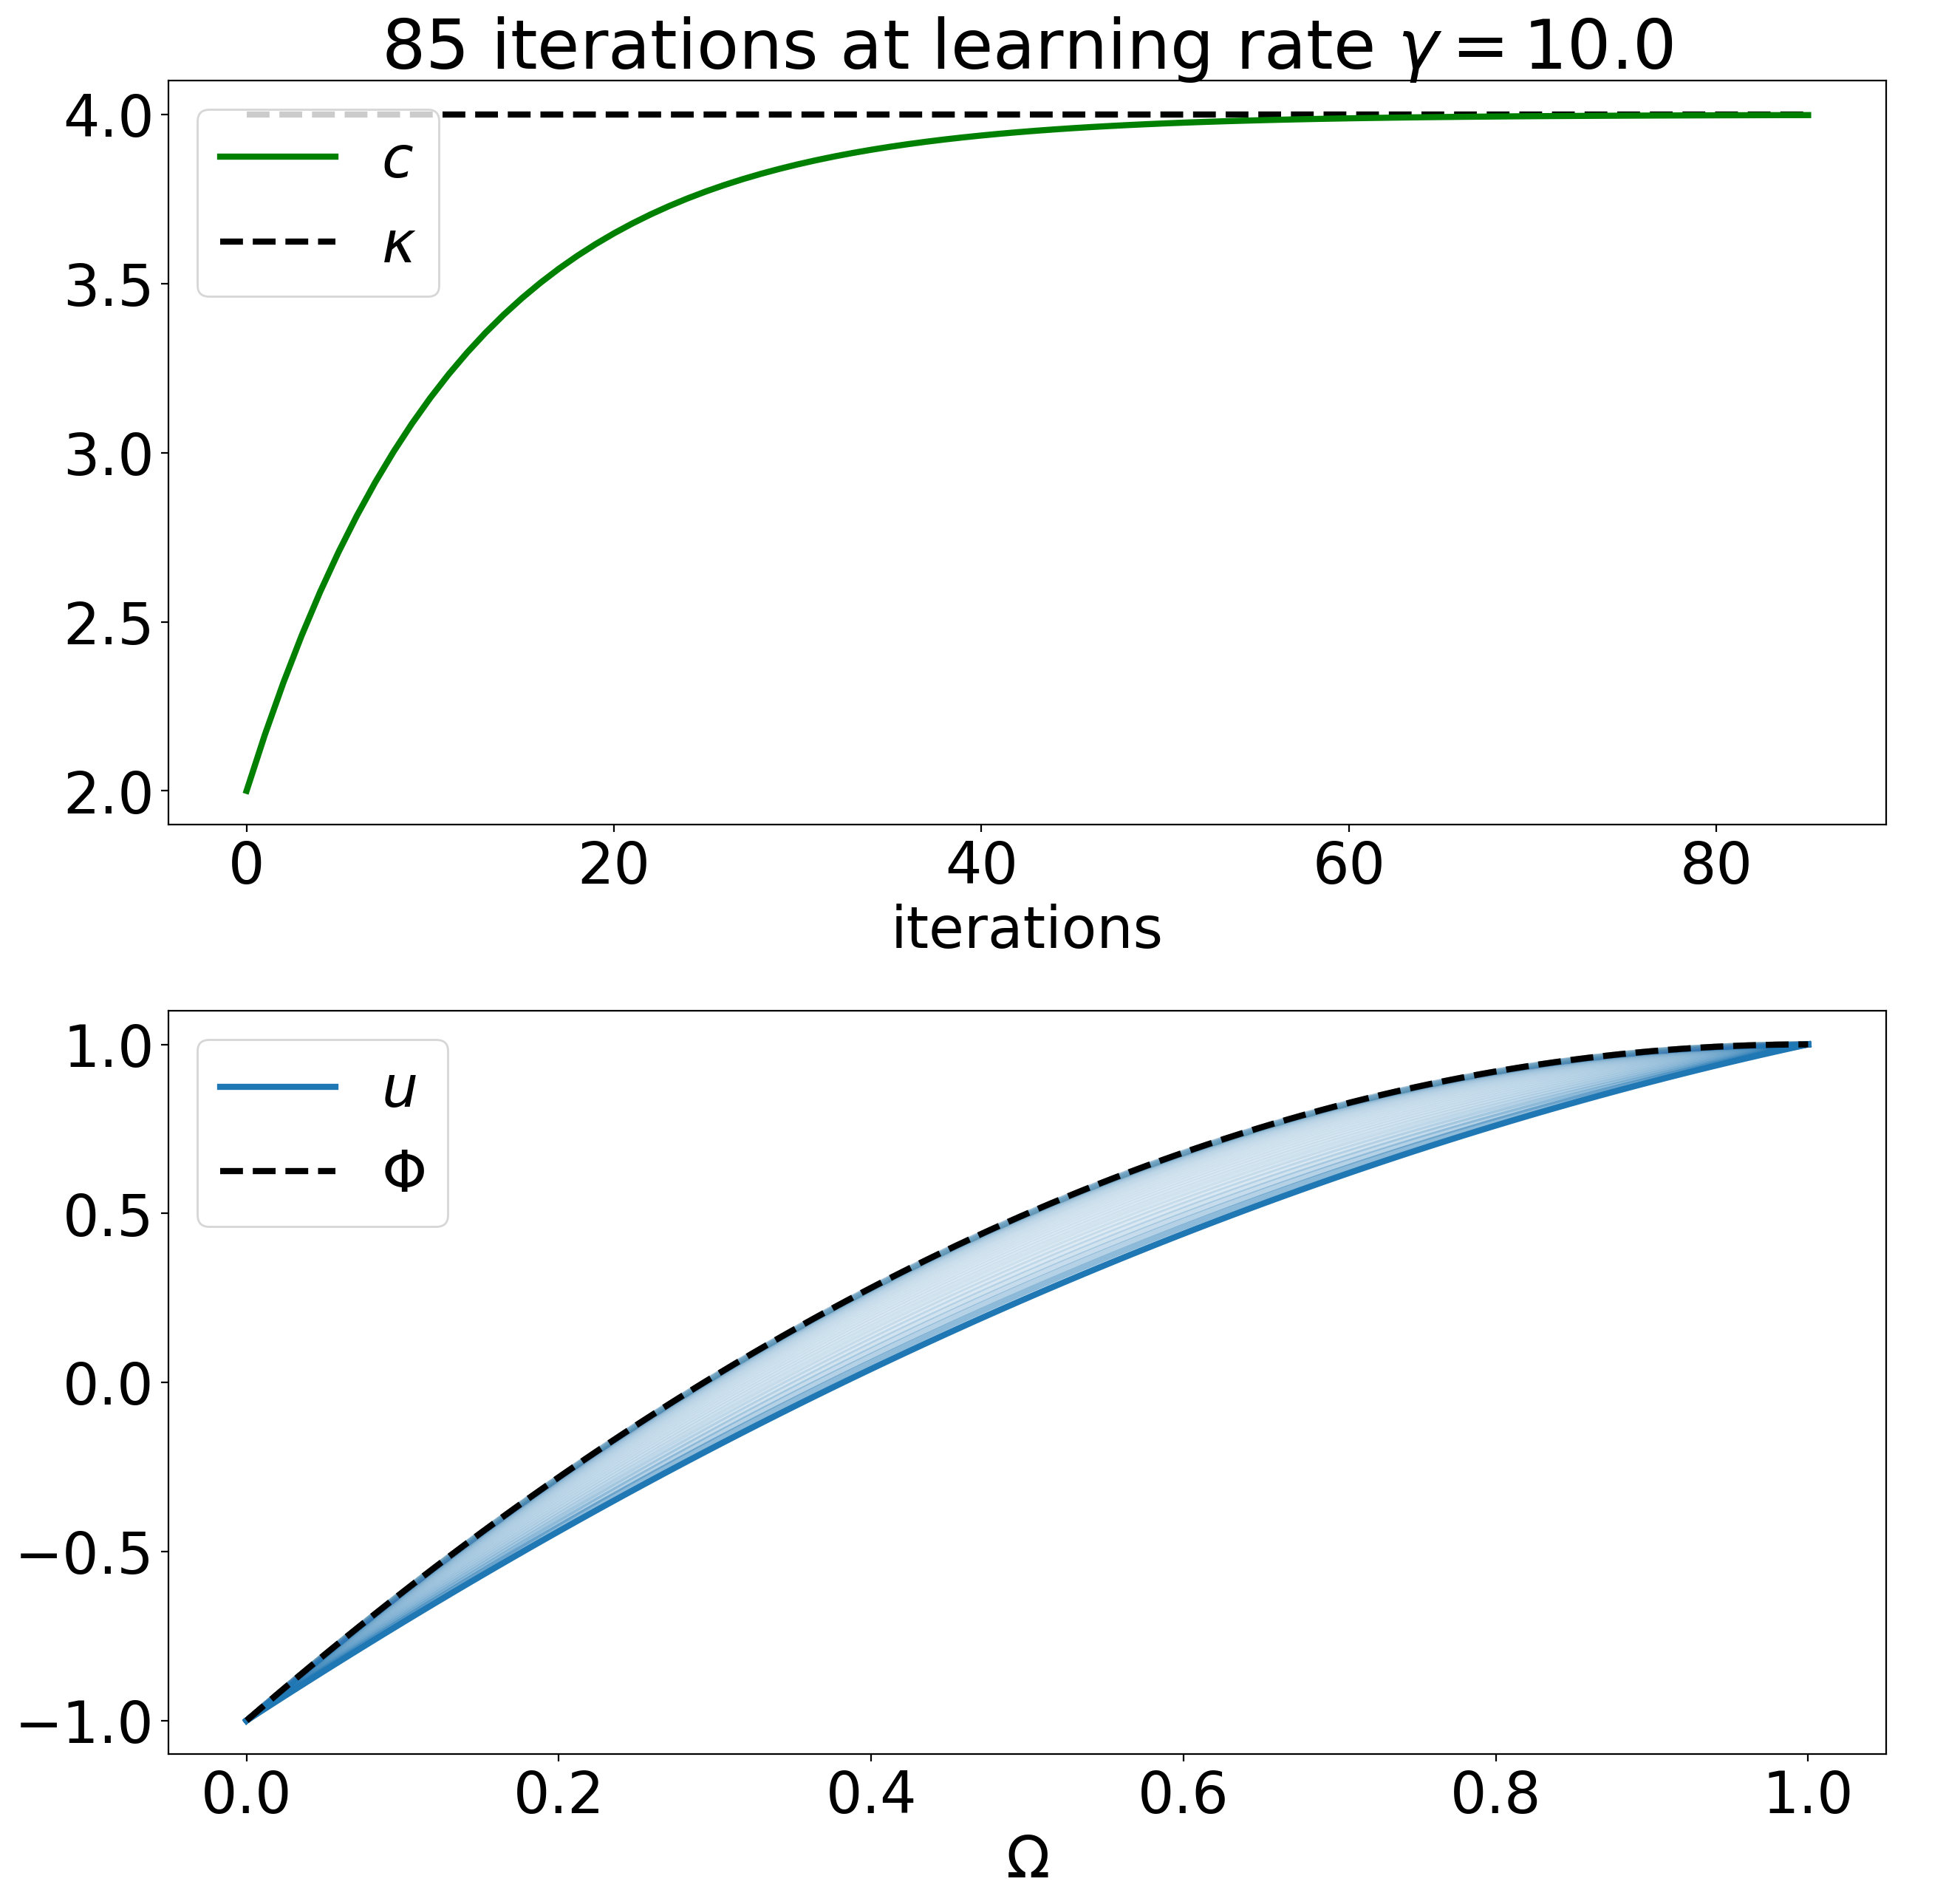

In [8]:
lr = 10.
tol = 1e-6
pois.descend(c_init, lr, tol)
pois.plot_grad_descent()

Just for fun, let's bump the learning rate up by an order of magnitude.
We should expect a much faster convergence to the optimum.

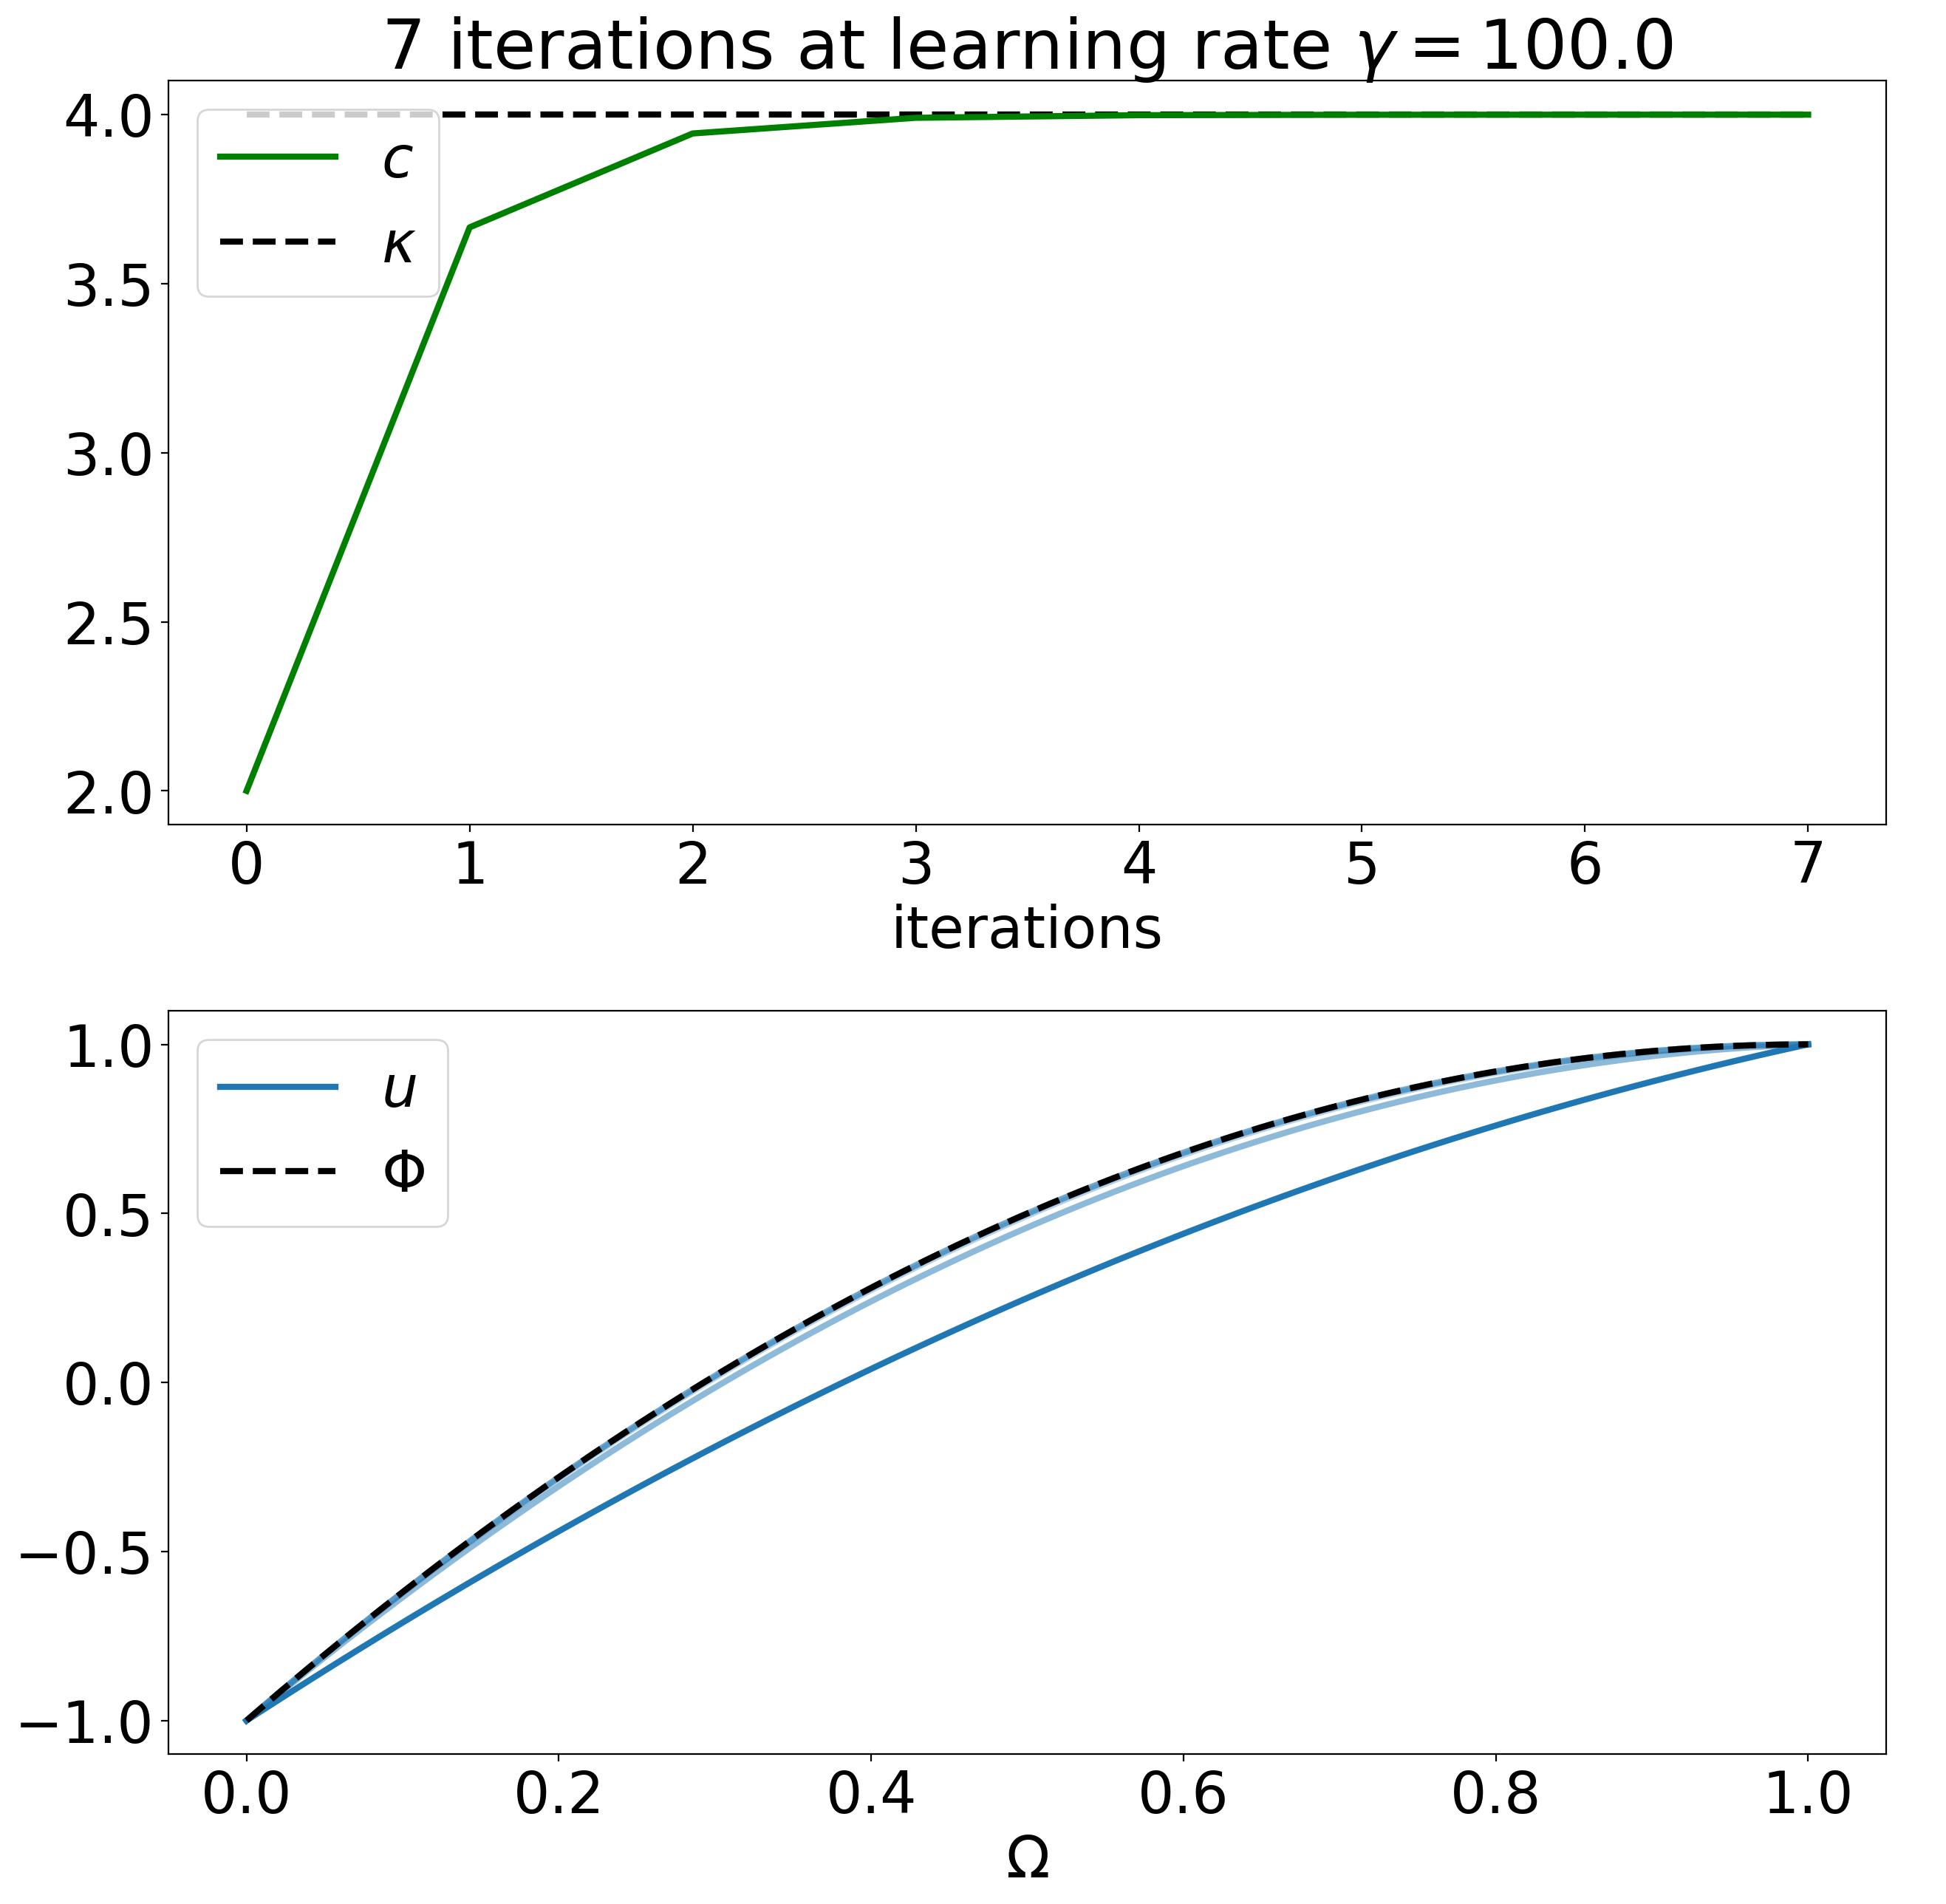

In [9]:
lr *= 10
pois.descend(c_init, lr, tol)
pois.plot_grad_descent()

And even more...

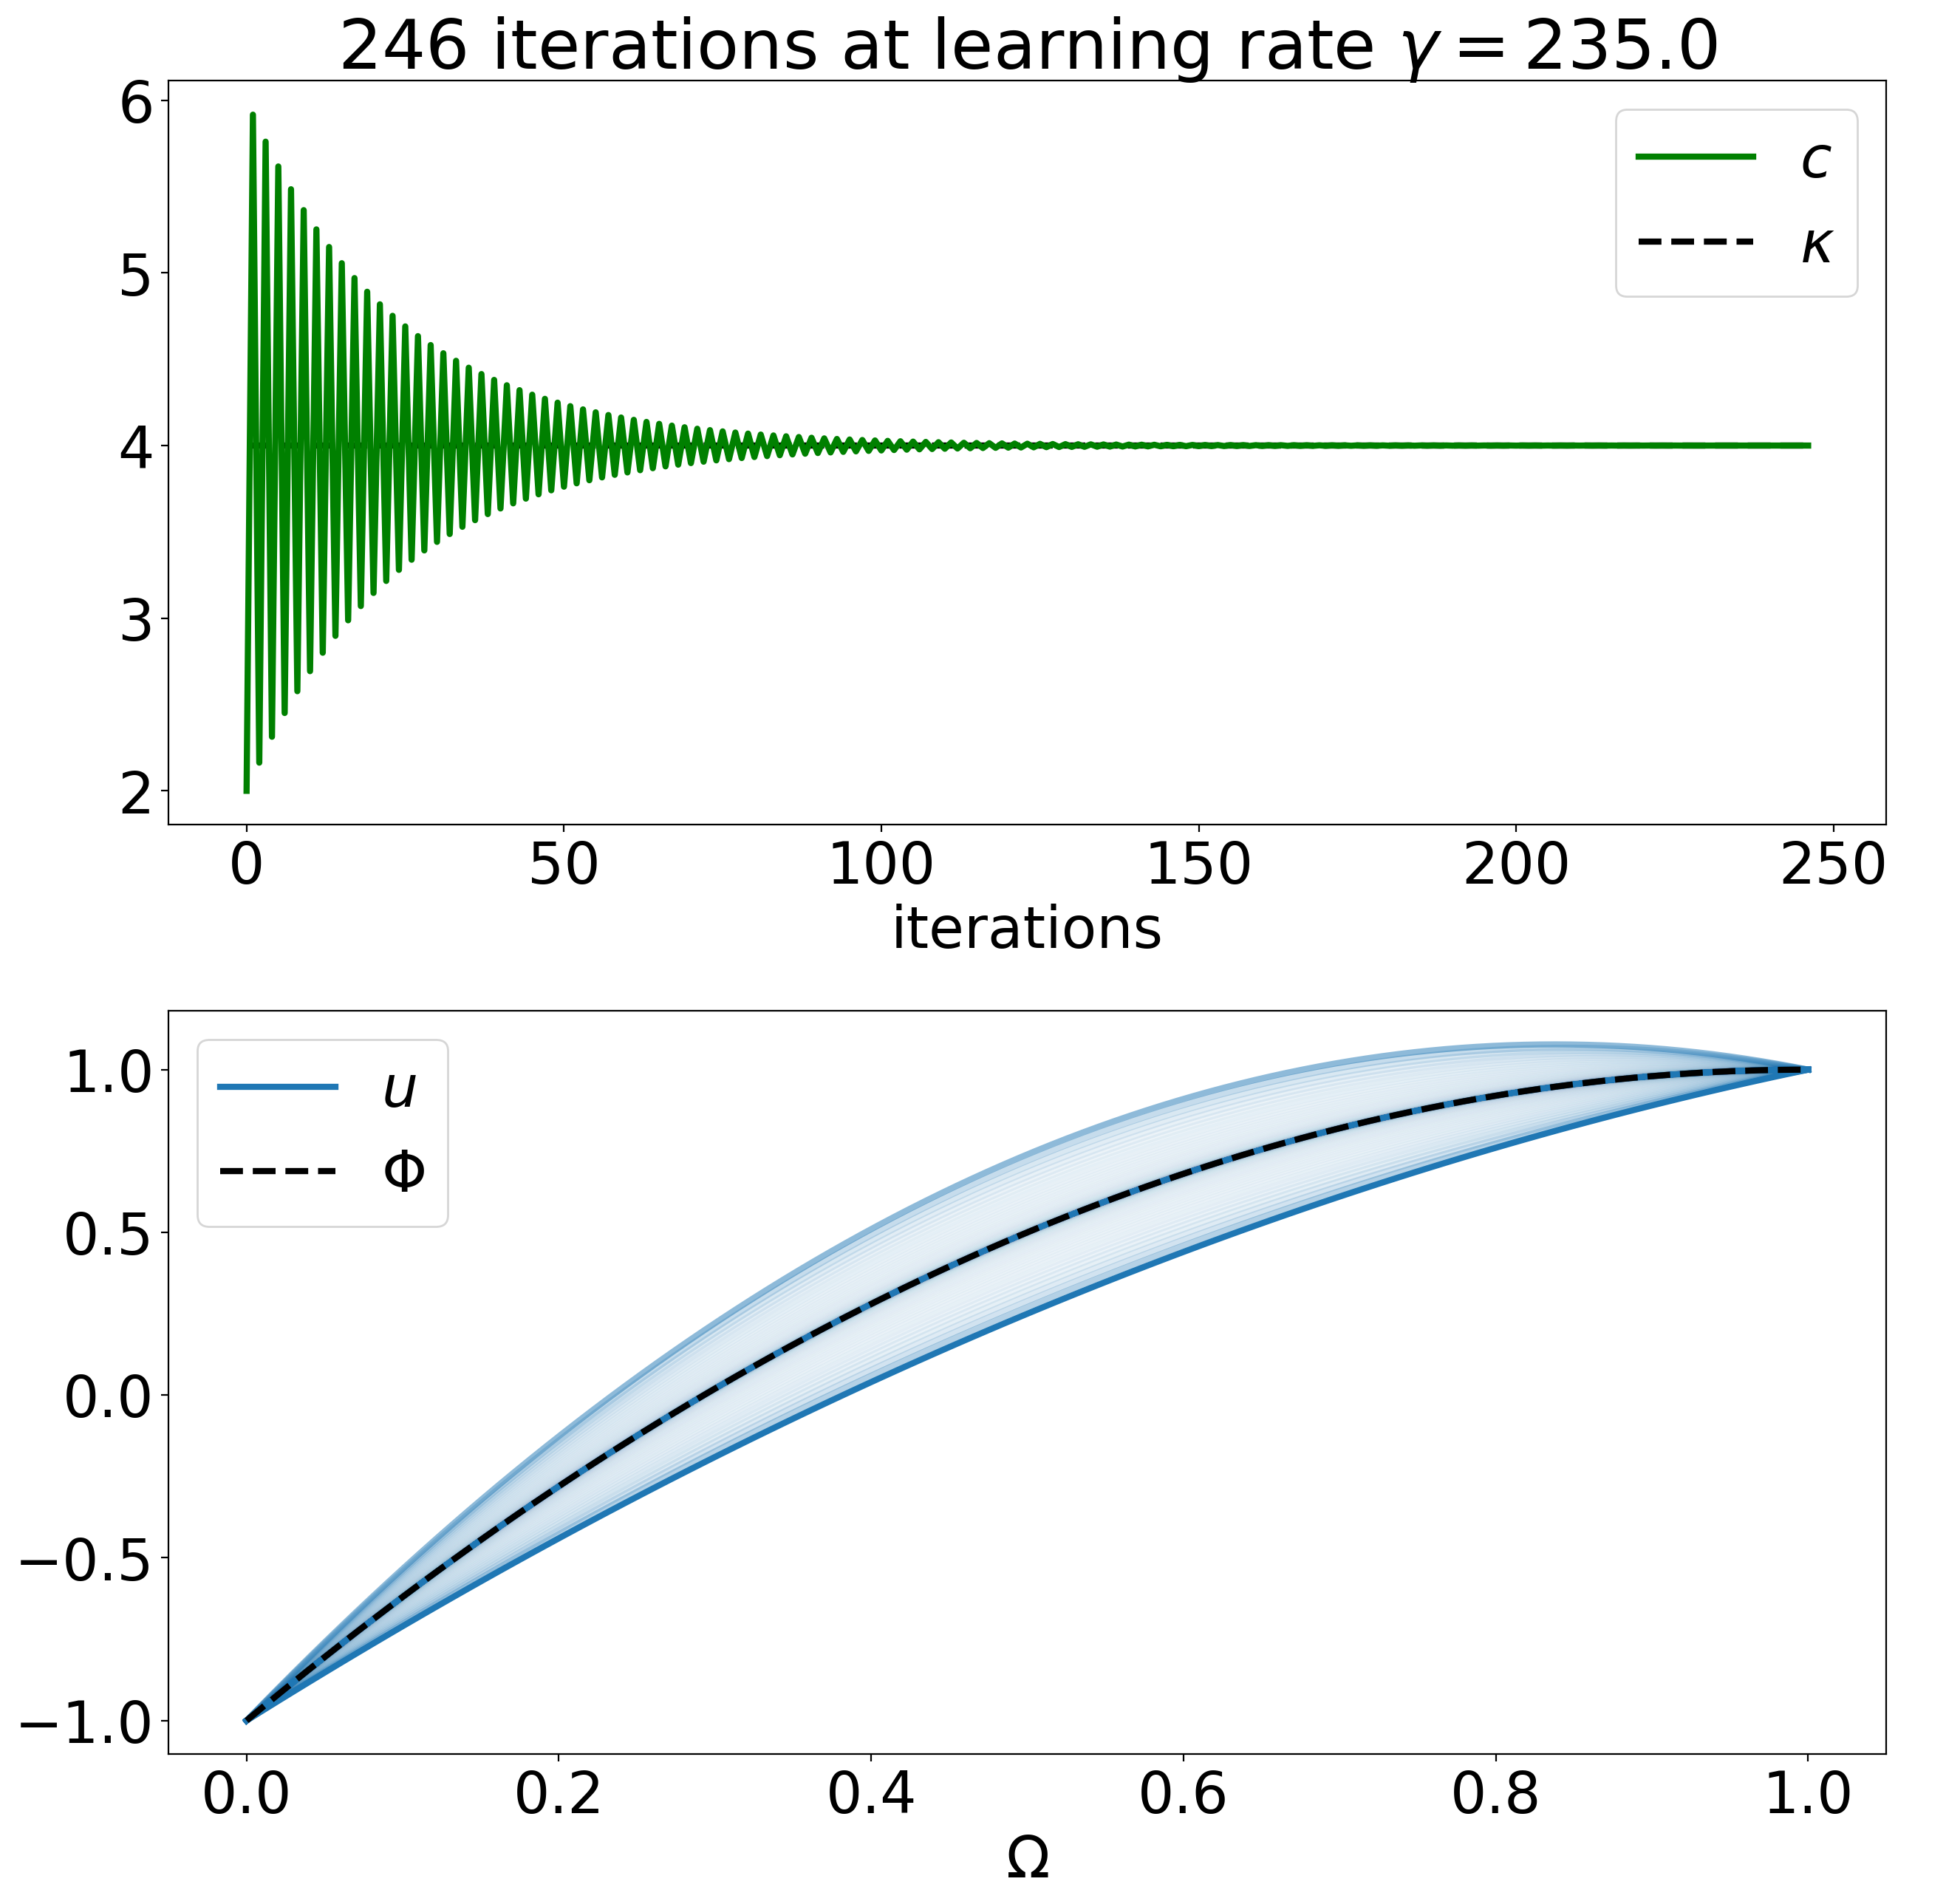

In [10]:
lr *= 2.35
pois.descend(c_init, lr, tol)
pois.plot_grad_descent()

Looks like the optimal learning rate is somewhere between 10 and 250. 
Maybe we can plot iterations to convergence as a function of $\gamma$.

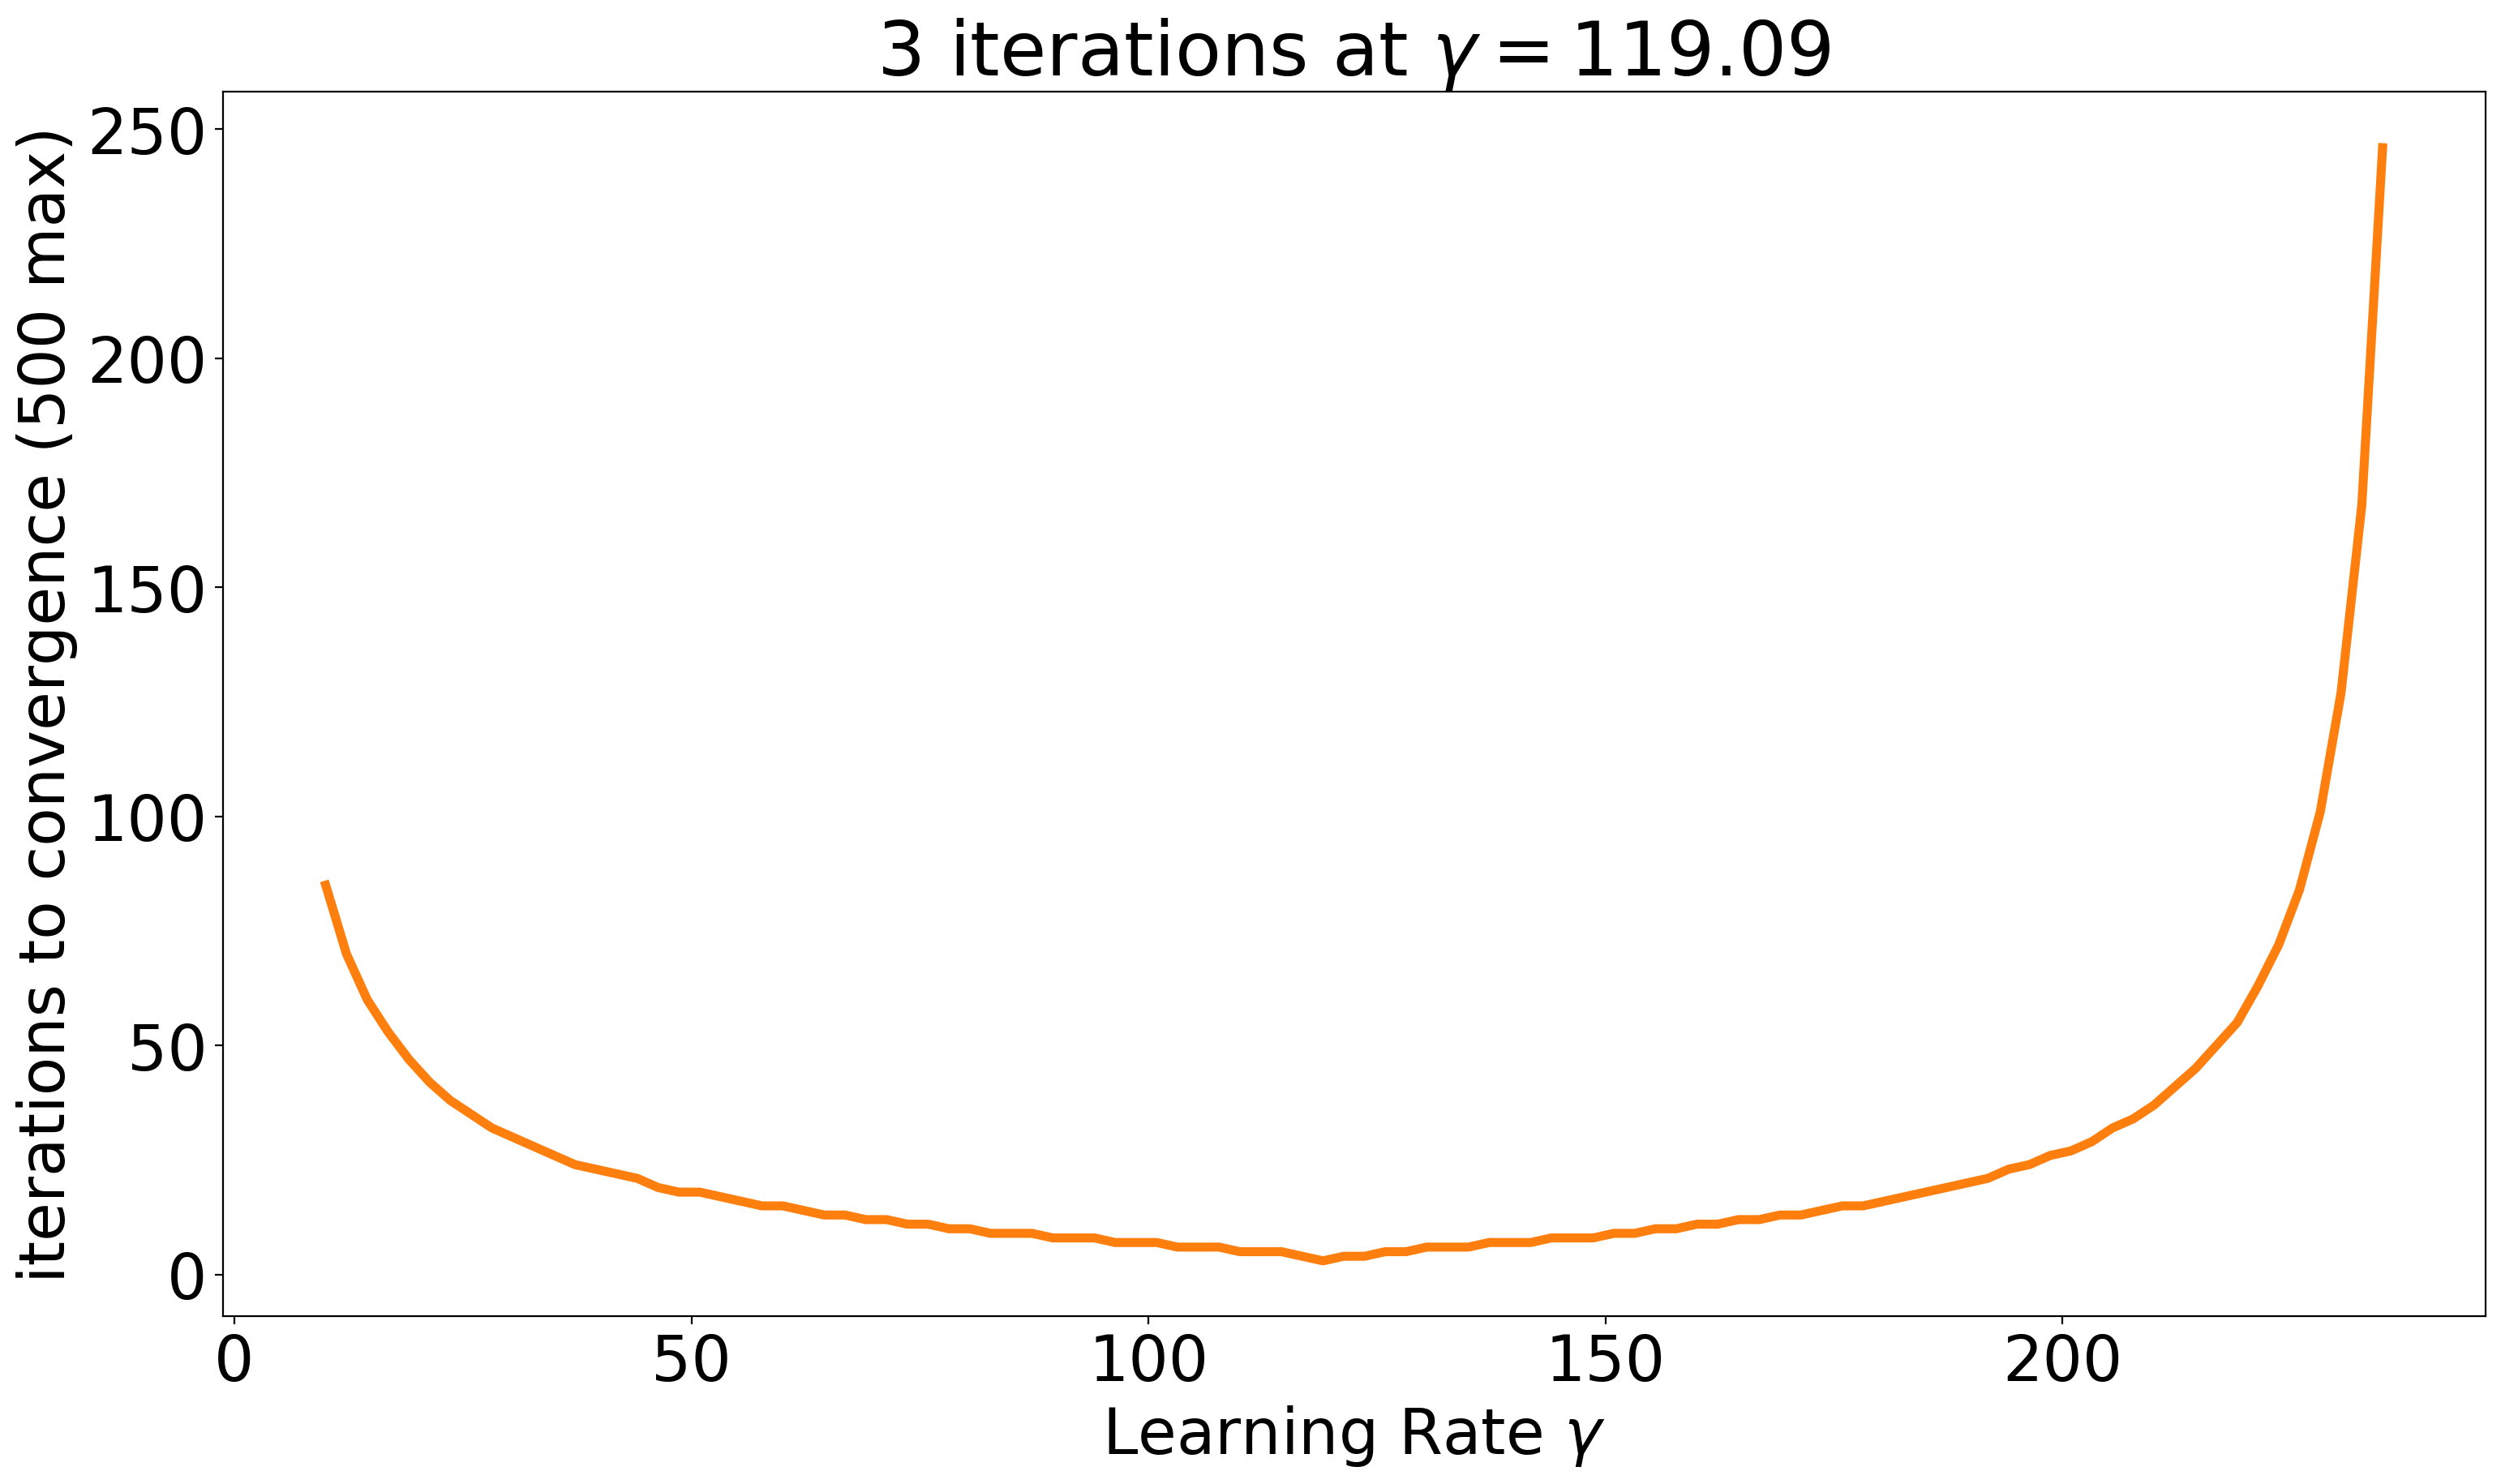

In [11]:
pois.plot_learning_rates(c_init, lr_bounds=[10., 235.], tol=tol)

Looks like we were very close to the optimal 
learning rate with our second guess!

# 3 Learning Boundary Conditions

Thus far we have assumed we are given the boundary values $b$.
But what if we don't _a priori_ know $b$ and want to learn it, 
in addition to $c$, from the data $\Phi$?
Said differently, how does $\mathcal{J}$ vary with
$\theta = (c, b_0, b_1)$?
To answer this, we will derive the adjoint equation
by introducing a new dual function $\mu$ for the boundary.

Just as before we assume the data $\Phi$ depends on some
unknown fixed force term $\kappa$, but also on unknown
boundary values $\beta_0$ and $\beta_1$. Explicitly,

$$
    u(x) = -\frac{c}{2} x^2 
        + \left( \frac{c}{2} + b_1 - b_0 \right) x 
        + b_0.
$$

and

$$
\Phi(x)
     = -\frac{\kappa}{2} x^2 
        + \left( \frac{\kappa}{2} + \beta_1 - \beta_0 \right) x 
        + \beta_0
$$

## 3.1 Lagrangian with Boundary Control

Note $F(u, \theta)$ encapsulates information about the Poisson
equation only on the domain $\Omega$, 
and not the boundary $\partial\Omega$.
Thus we need a separate constraint equation for the boundary conditions.
To that end, define $G(u, \theta) = u - b$ so that
$G(u, \theta) = 0$ on $\partial\Omega$. 
This naturally gives rise to a new adjoint variable $\mu$
for the boundary.
Our updated Lagrangian becomes


$$
    \mathcal{L}(u, \theta, \lambda) = 
        J(u, \theta) - \lambda^* F(u, \theta) - \mu^* G(u, \theta).
$$

So to derive the new adjoint PDE that includes boundary control
we first observe $\frac{\partial G}{\partial u} = 1$.
Now we compute $\frac{\delta\mathcal{L}}{\delta u}$ 
just as before: integrate by parts twice to remove differential
operators from $\tilde u$ as much as possible. Observe,

$$
\begin{align*}
    \frac{\partial\mathcal{L}}{\partial u}^* \lambda
    = \int_\Omega\! \tilde u ( u - \Phi - \Delta\lambda)\, dx
        + \int_{\partial\Omega}\!
        \tilde u\left(\frac{\partial\lambda}{\partial n}-\mu\right)
        - \int_{\partial\Omega}\!
        \frac{\partial\tilde u}{\partial n}\lambda
      = 0.
\end{align*}
$$

### 3.1.1 Analytic Calculations
We seek a solution to the above equation for arbitrary $\tilde u$,
implying the integrands, not including $\tilde u$,
must be identically zero.
Therefore the adjoint Poisson equation is

$$
\begin{align*}
    \Delta\lambda &= u - \Phi & &\text{on } \Omega \\
    \lambda &= 0 & &\text{on } \partial\Omega \\
    \mu &= \frac{\partial\lambda}{\partial n} & &\text{on }\partial\Omega
\end{align*}
$$

From our assumed form of $\Phi$, the force term here is

$$
    u - \Phi = \frac{\tilde c}{2} (x-x^2)
        + \tilde b_0(1-x)
        + \tilde b_1x
$$

for auxiliary parameters $\tilde c = c - \kappa$,
$\tilde b_0 = b_0 - \beta_0$, and $\tilde b_1 = b_1 - \beta_1$.
By independence of the auxiliary parameters, 
each term in the above equation must vanish at the boundary.
Therefore,

$$
    \lambda(x) = \frac{\tilde c}{24}\left(2x^3 - x^4 - x\right)
        + \frac{\tilde b_0}{6}\left( 3x^2 - x^3 - 2x \right)
        + \frac{\tilde b_1}{6}\left( x^3 - x \right)
$$

At the boundary $\mu$ is given by the outward unit normal derivative of $\lambda$, i.e.

$$
    \mu_0 = -\lambda'(0) = \frac{\tilde c}{24}
        + \frac{\tilde b_0}{3} + \frac{\tilde b_1}{6} 
$$

and

$$
    \mu_1 = \lambda'(1) = \frac{\tilde c}{24} 
        + \frac{\tilde b_0}{6}
        + \frac{\tilde b_1}{3}
$$

Now, 

$$
    \frac{\partial F}{\partial\theta} = \begin{pmatrix} 1 & 0 & 0 \end{pmatrix}
    \quad\text{and}\quad 
    \frac{\partial G}{\partial\theta}
        = \begin{pmatrix}
            0 & -1 & 0  \\
            0 &  0 & -1
        \end{pmatrix}
$$

which gives a constrained loss gradient of

$$
    \frac{d\mathcal{J}}{d\theta} 
      = -\begin{pmatrix}\int_\Omega \lambda\,dx & 0 & 0 \end{pmatrix} 
        - \begin{pmatrix}\mu_0 & \mu_1\end{pmatrix}\frac{\partial G}{\partial\theta}
$$

or, equivalently,

$$\boxed{
    \frac{d\mathcal{J}}{d\theta} 
      = \frac{c-\kappa}{120}
         \begin{pmatrix} 
              1 \\ 
              5 \\ 
              5
         \end{pmatrix}^* +
         \frac{b_0 - \beta_0}{24}
         \begin{pmatrix}
             1 \\
             8 \\
             4
         \end{pmatrix}^* +
         \frac{b_1 - \beta_1}{24}
         \begin{pmatrix}
             1 \\
             4 \\
             8
         \end{pmatrix}^*
}$$

## 3.2 Visualizing Convergence to the Optimum

Recall the following algorithm to compute the desired gradient:

1. Make an initial guess at $\theta$ and 
solve the Poisson equation
$\frac{\delta\mathcal{L}}{\delta\lambda} = 0$ for $u$
2. Solve the Poisson adjoint equation for interior and boundary adjoint functions $\lambda$ and $\mu$
3. The desired gradient is given by

$$
    \frac{d\mathcal{J}}{d\theta} 
        = -\lambda^* \frac{dF}{d\theta} - \mu^* \frac{dG}{d\theta}
$$

Let's continue the example from section 2, 
with $\kappa = 4$, $\beta_0 = 1$, and $\beta_1 = -1$.
From the analytic constrained gradient formula
if we make a guess of $\theta = (2, -1, 1)$ we should have

$$
    \frac{d\mathcal{J}}{d\theta} 
      = \begin{pmatrix}
          -\frac{1}{60} \\
          -\frac{5}{12} \\
          \frac{1}{4}
      \end{pmatrix}
$$

When boundary conditions are not known we can use
the class `PoissonBC` to minimize loss with boundary control.
Let's first perform the descent and take a look at the flow.

In [35]:
from autoencoder.adjoint import PoissonBC

theta_true = [4., 1., -1.]
theta_init = [2., -1., 1.]
pois_bc = PoissonBC(theta_true, resolution=50)
pois_bc.test_get_grad(theta_init)

analytic gradient: [[-0.01666667 -0.41666667  0.25      ]]
numerical gradient: [[-0.01666666 -0.3969      0.2303    ]]


In [36]:
lr = 1.0
tol = 1e-6
pois_bc.descend(theta_init, lr, tol)

#### Convergence in solution space

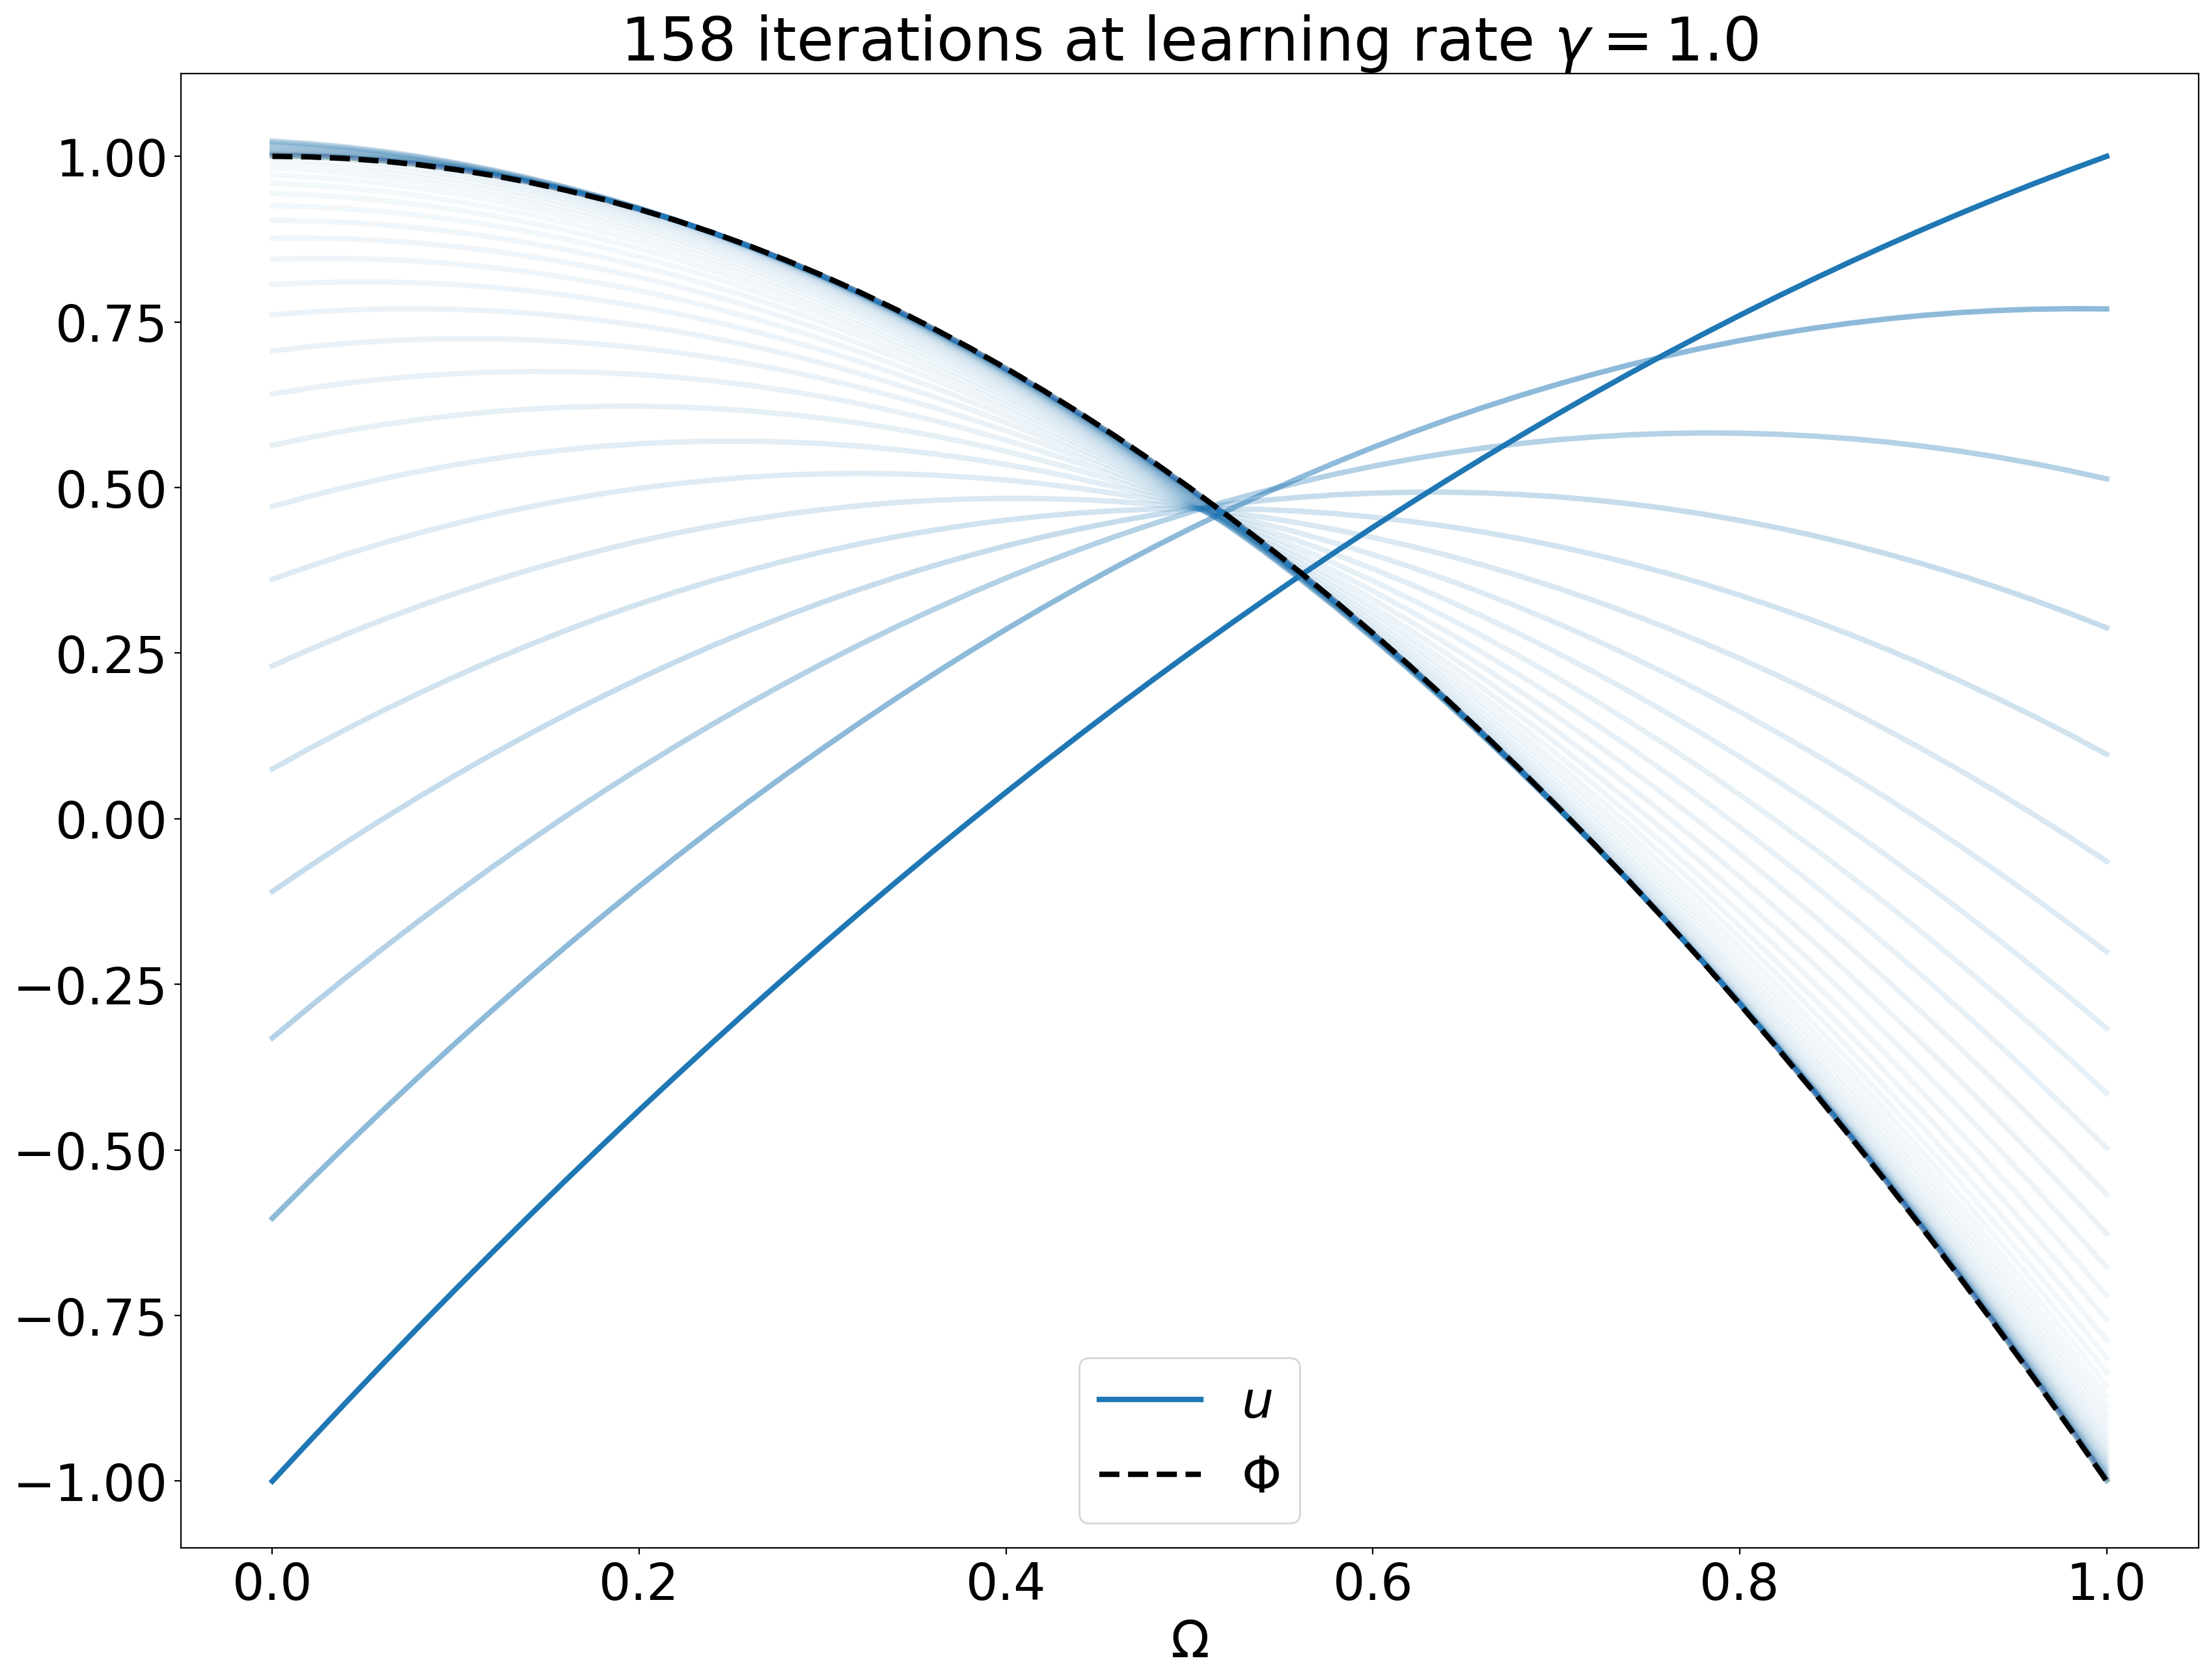

In [37]:
pois_bc.plot_curve_convergence()

#### Convergence in parameter space

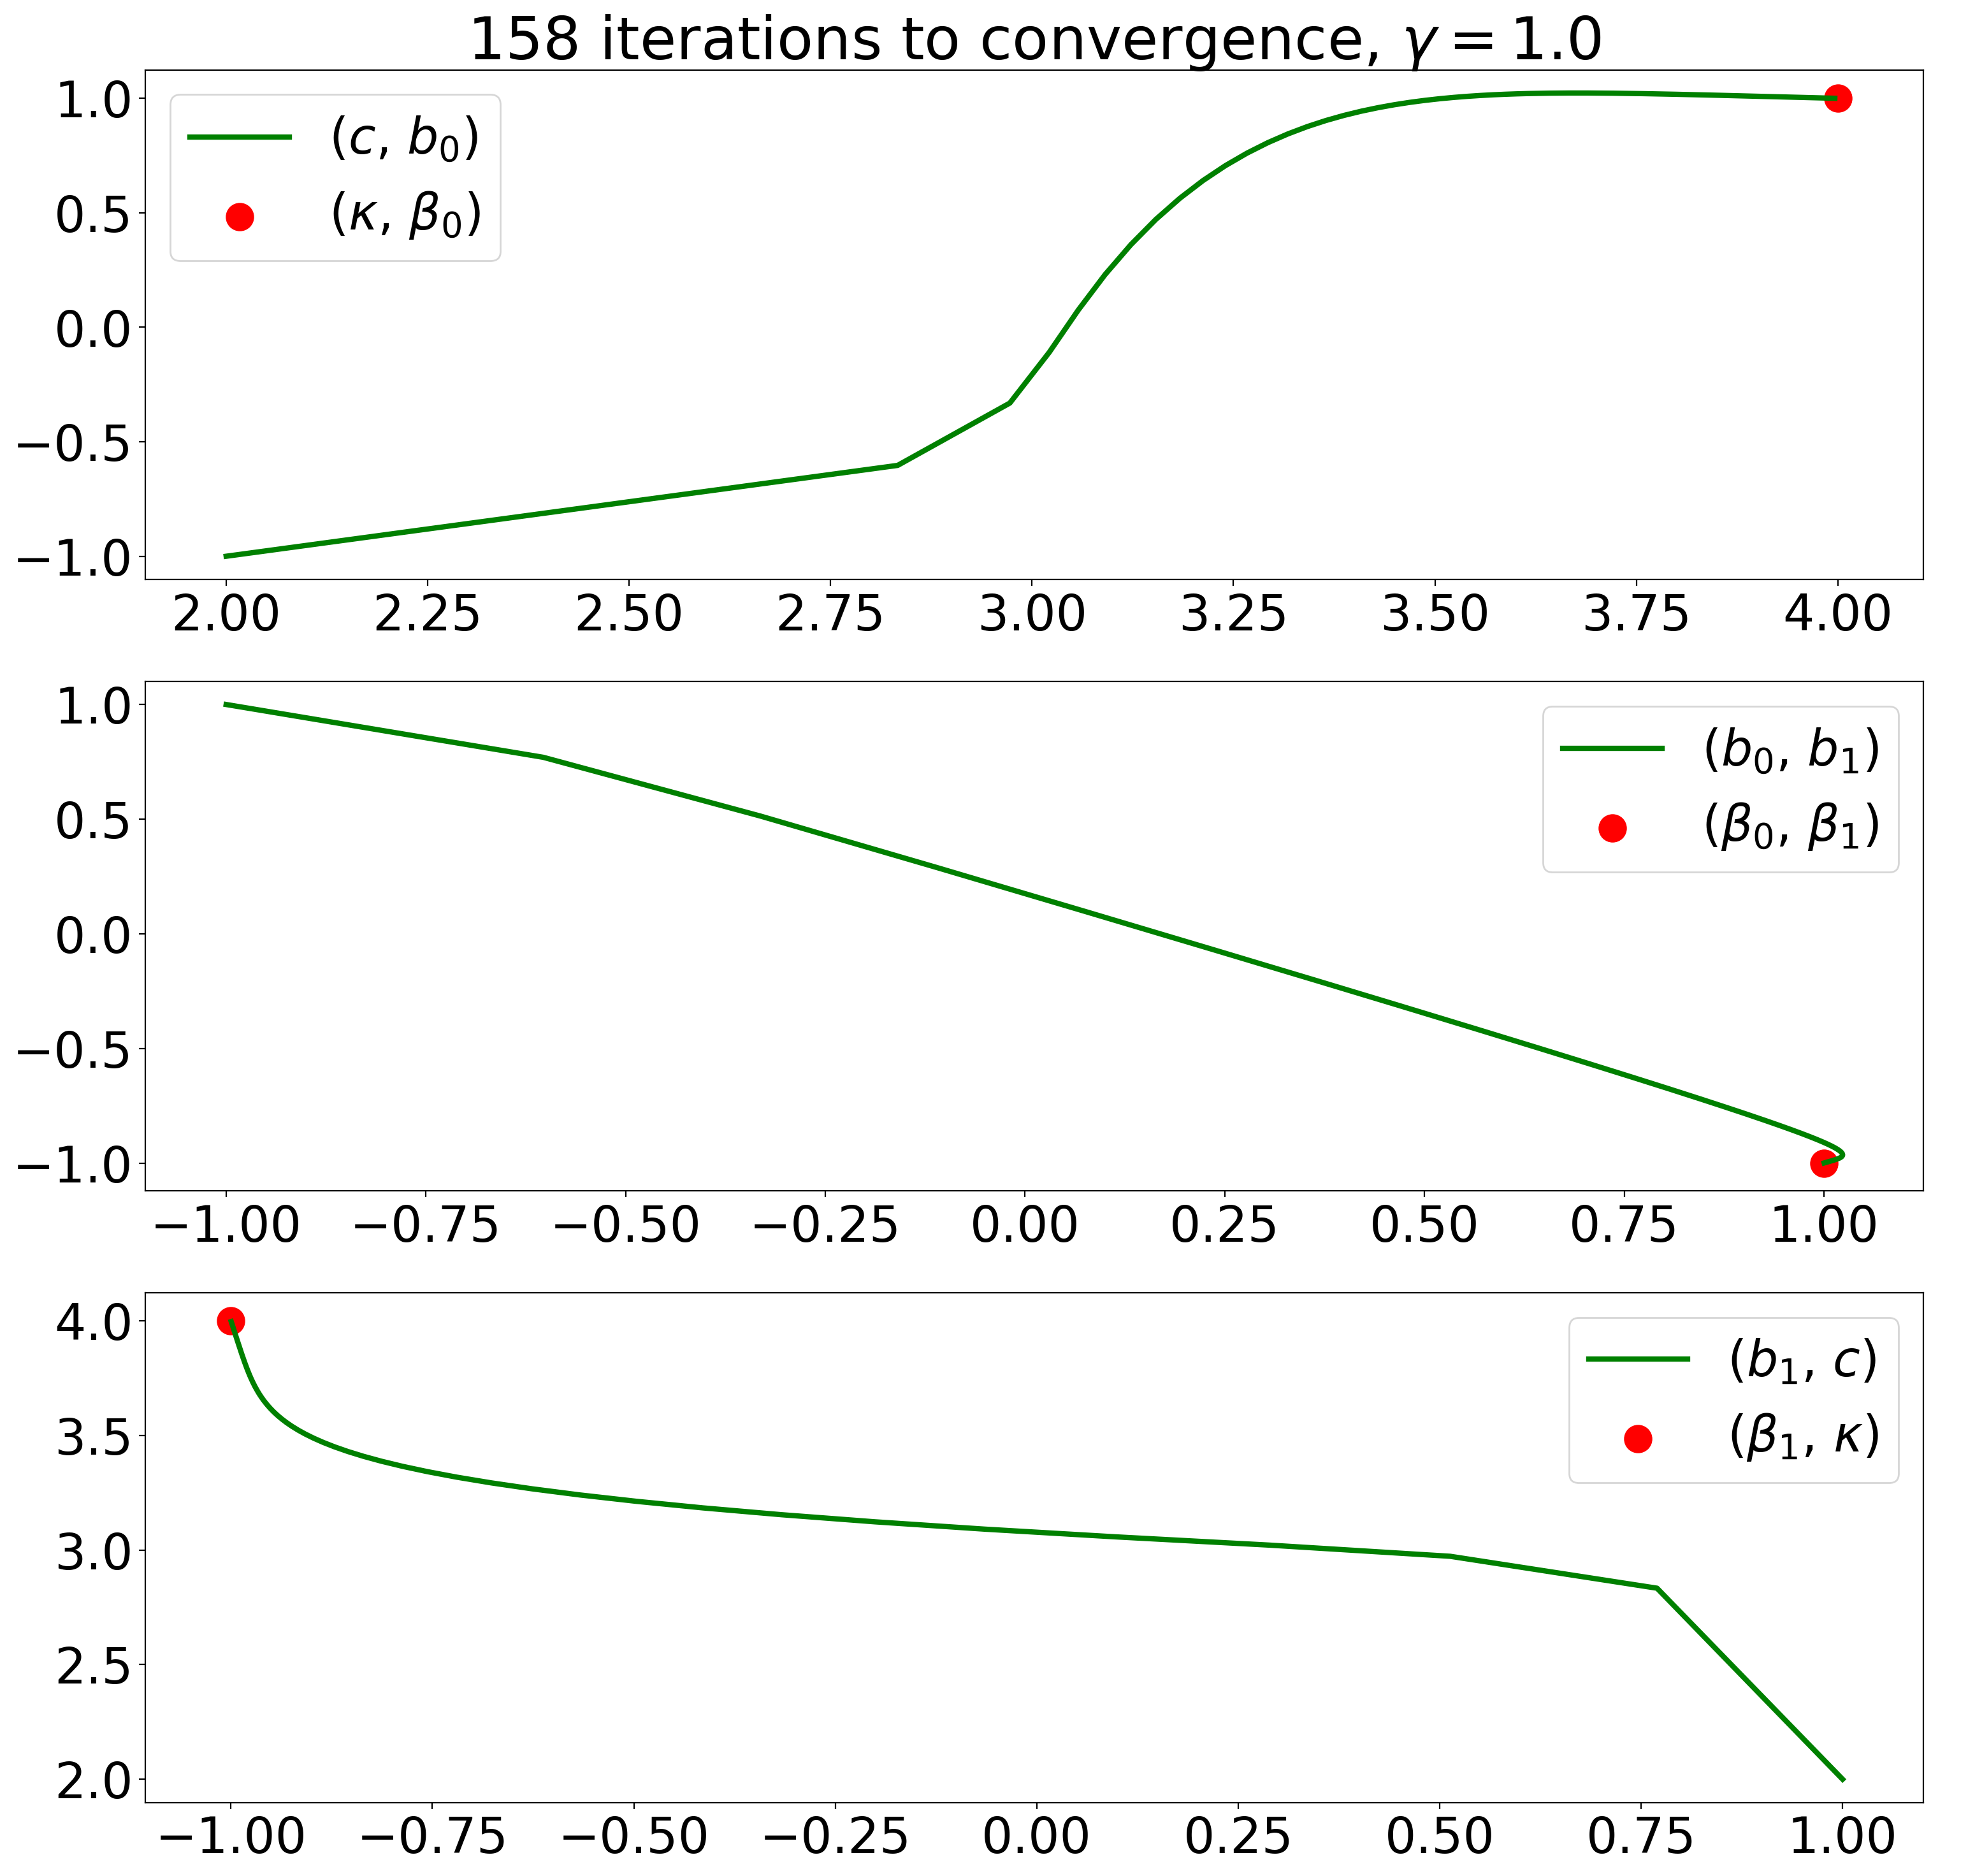

In [38]:
pois_bc.biplot_grad_descent()

#### Rate of convergence

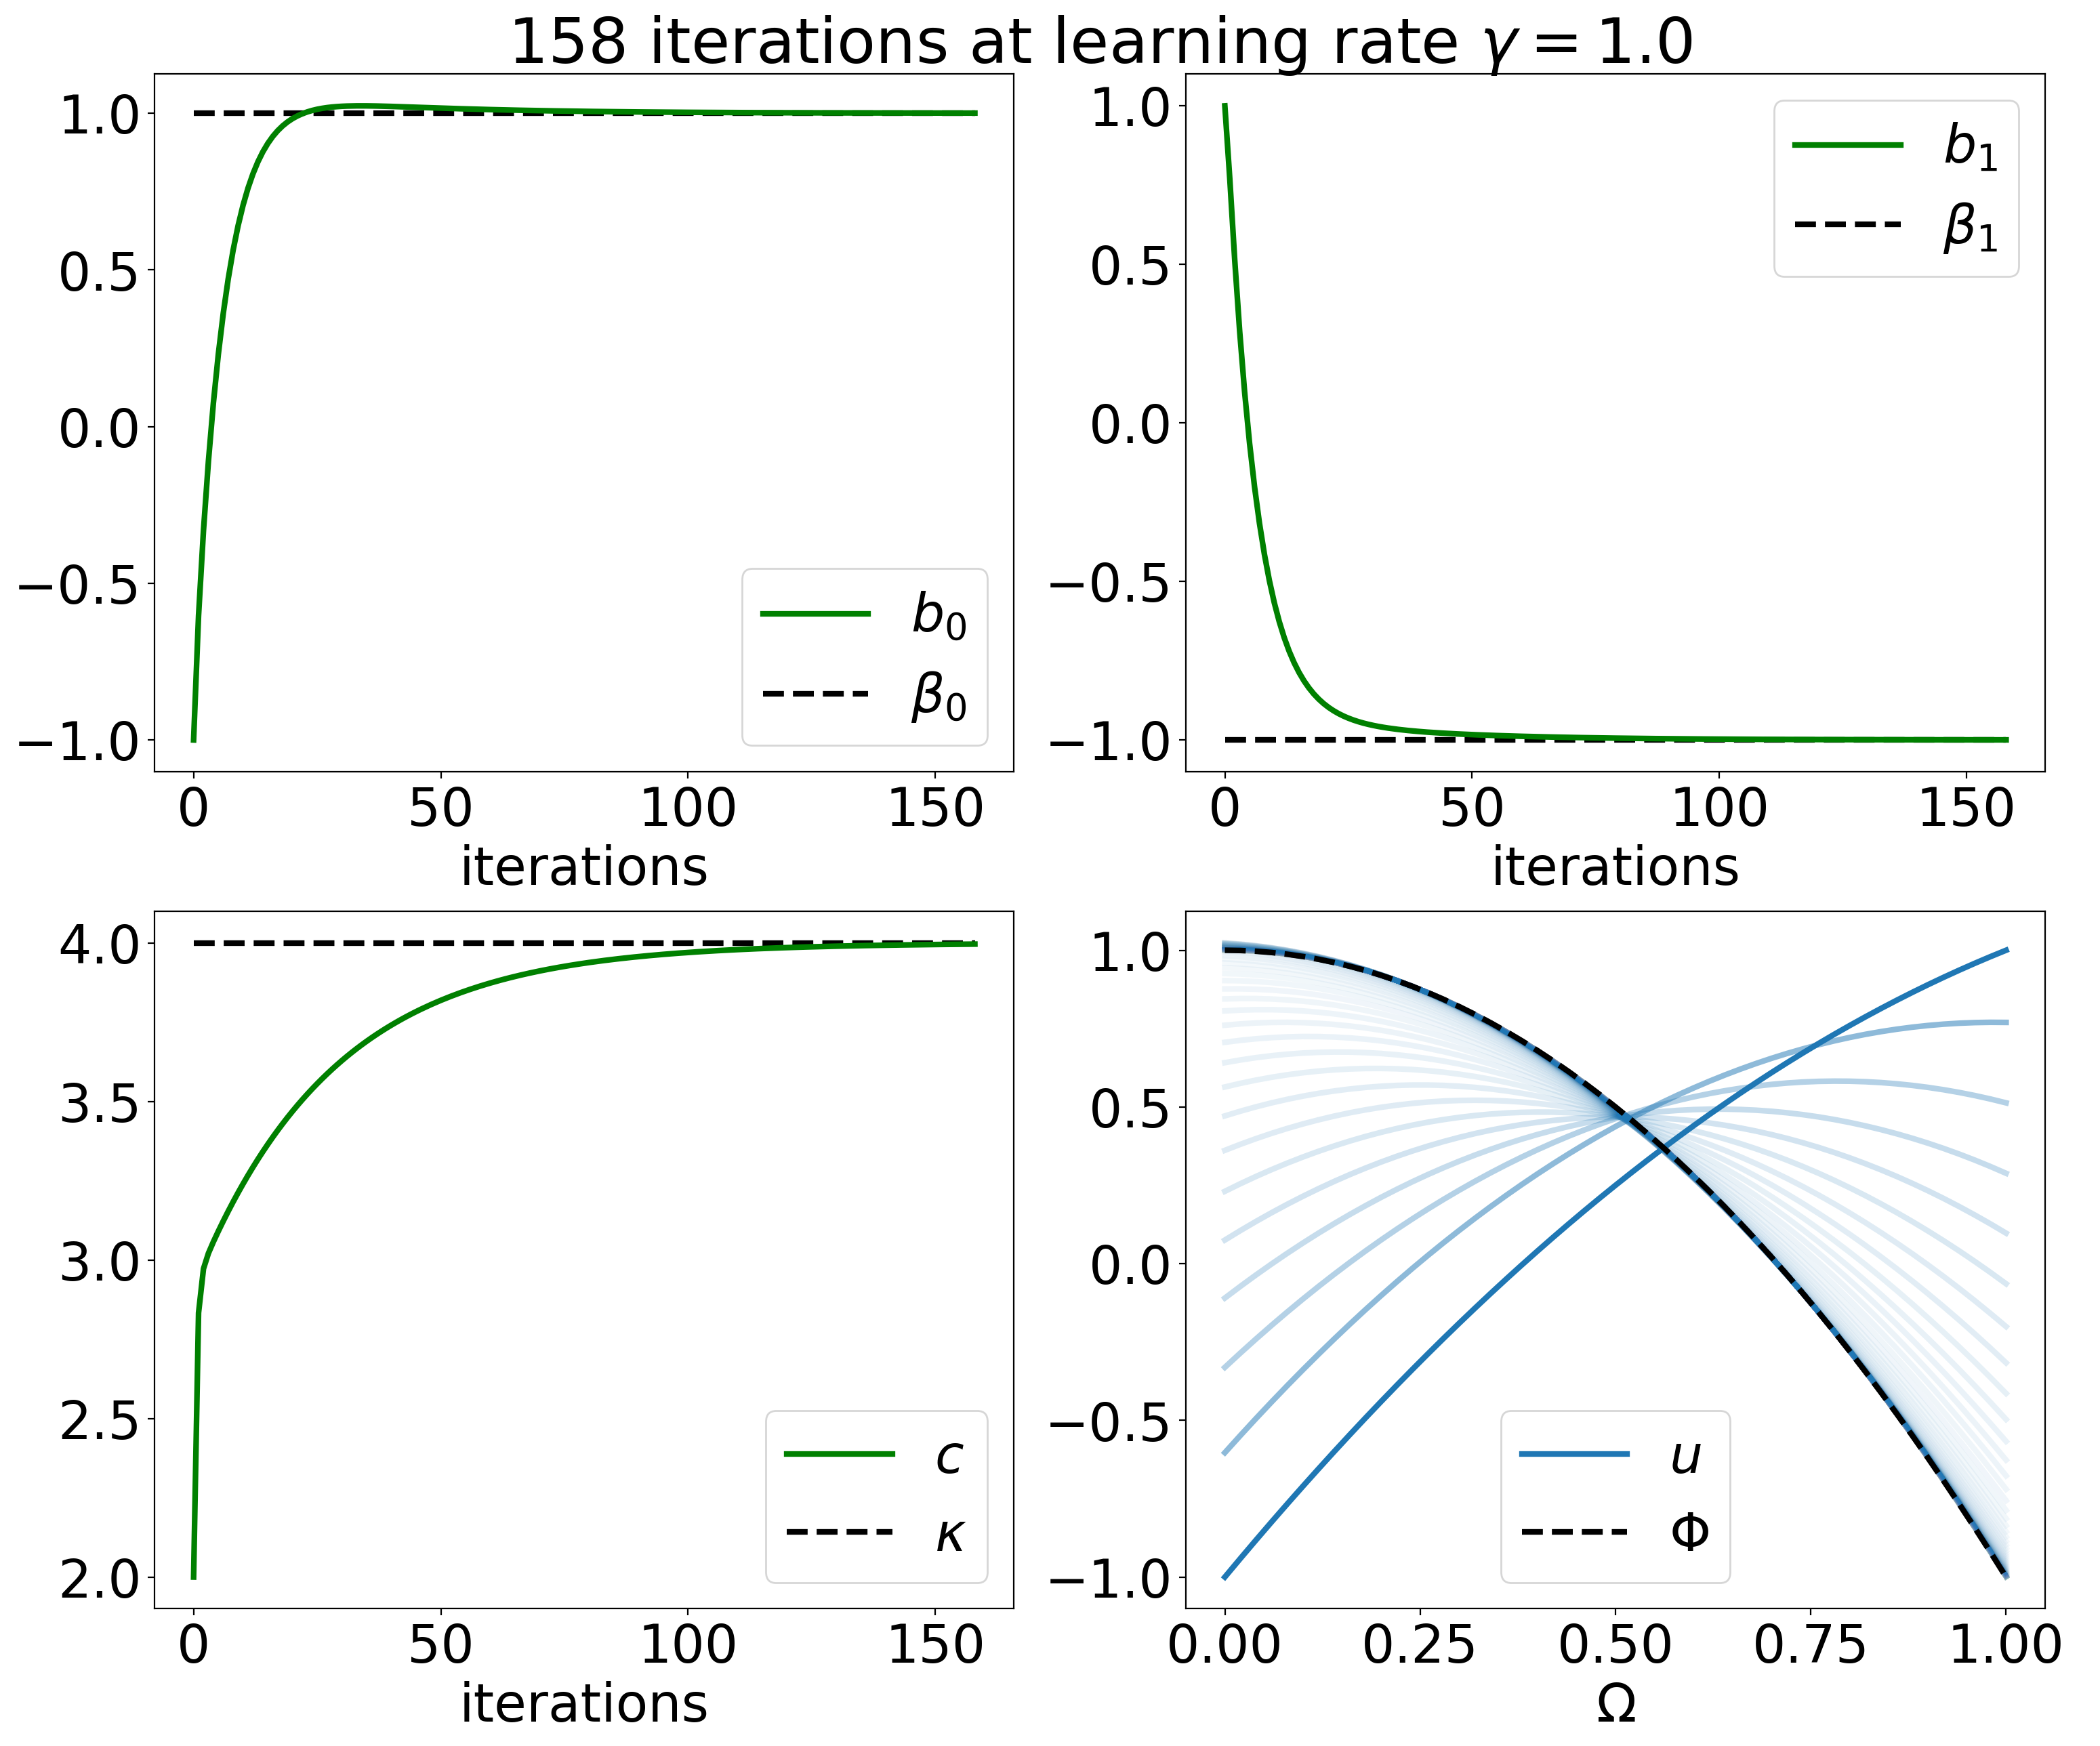

In [39]:
pois_bc.plot_grad_descent()

Convergence looks slower than before, perhaps because of
a loss surface that is non-convex.
Let's do gradient descent for a range of learning rates.

#### Optimal learning rate

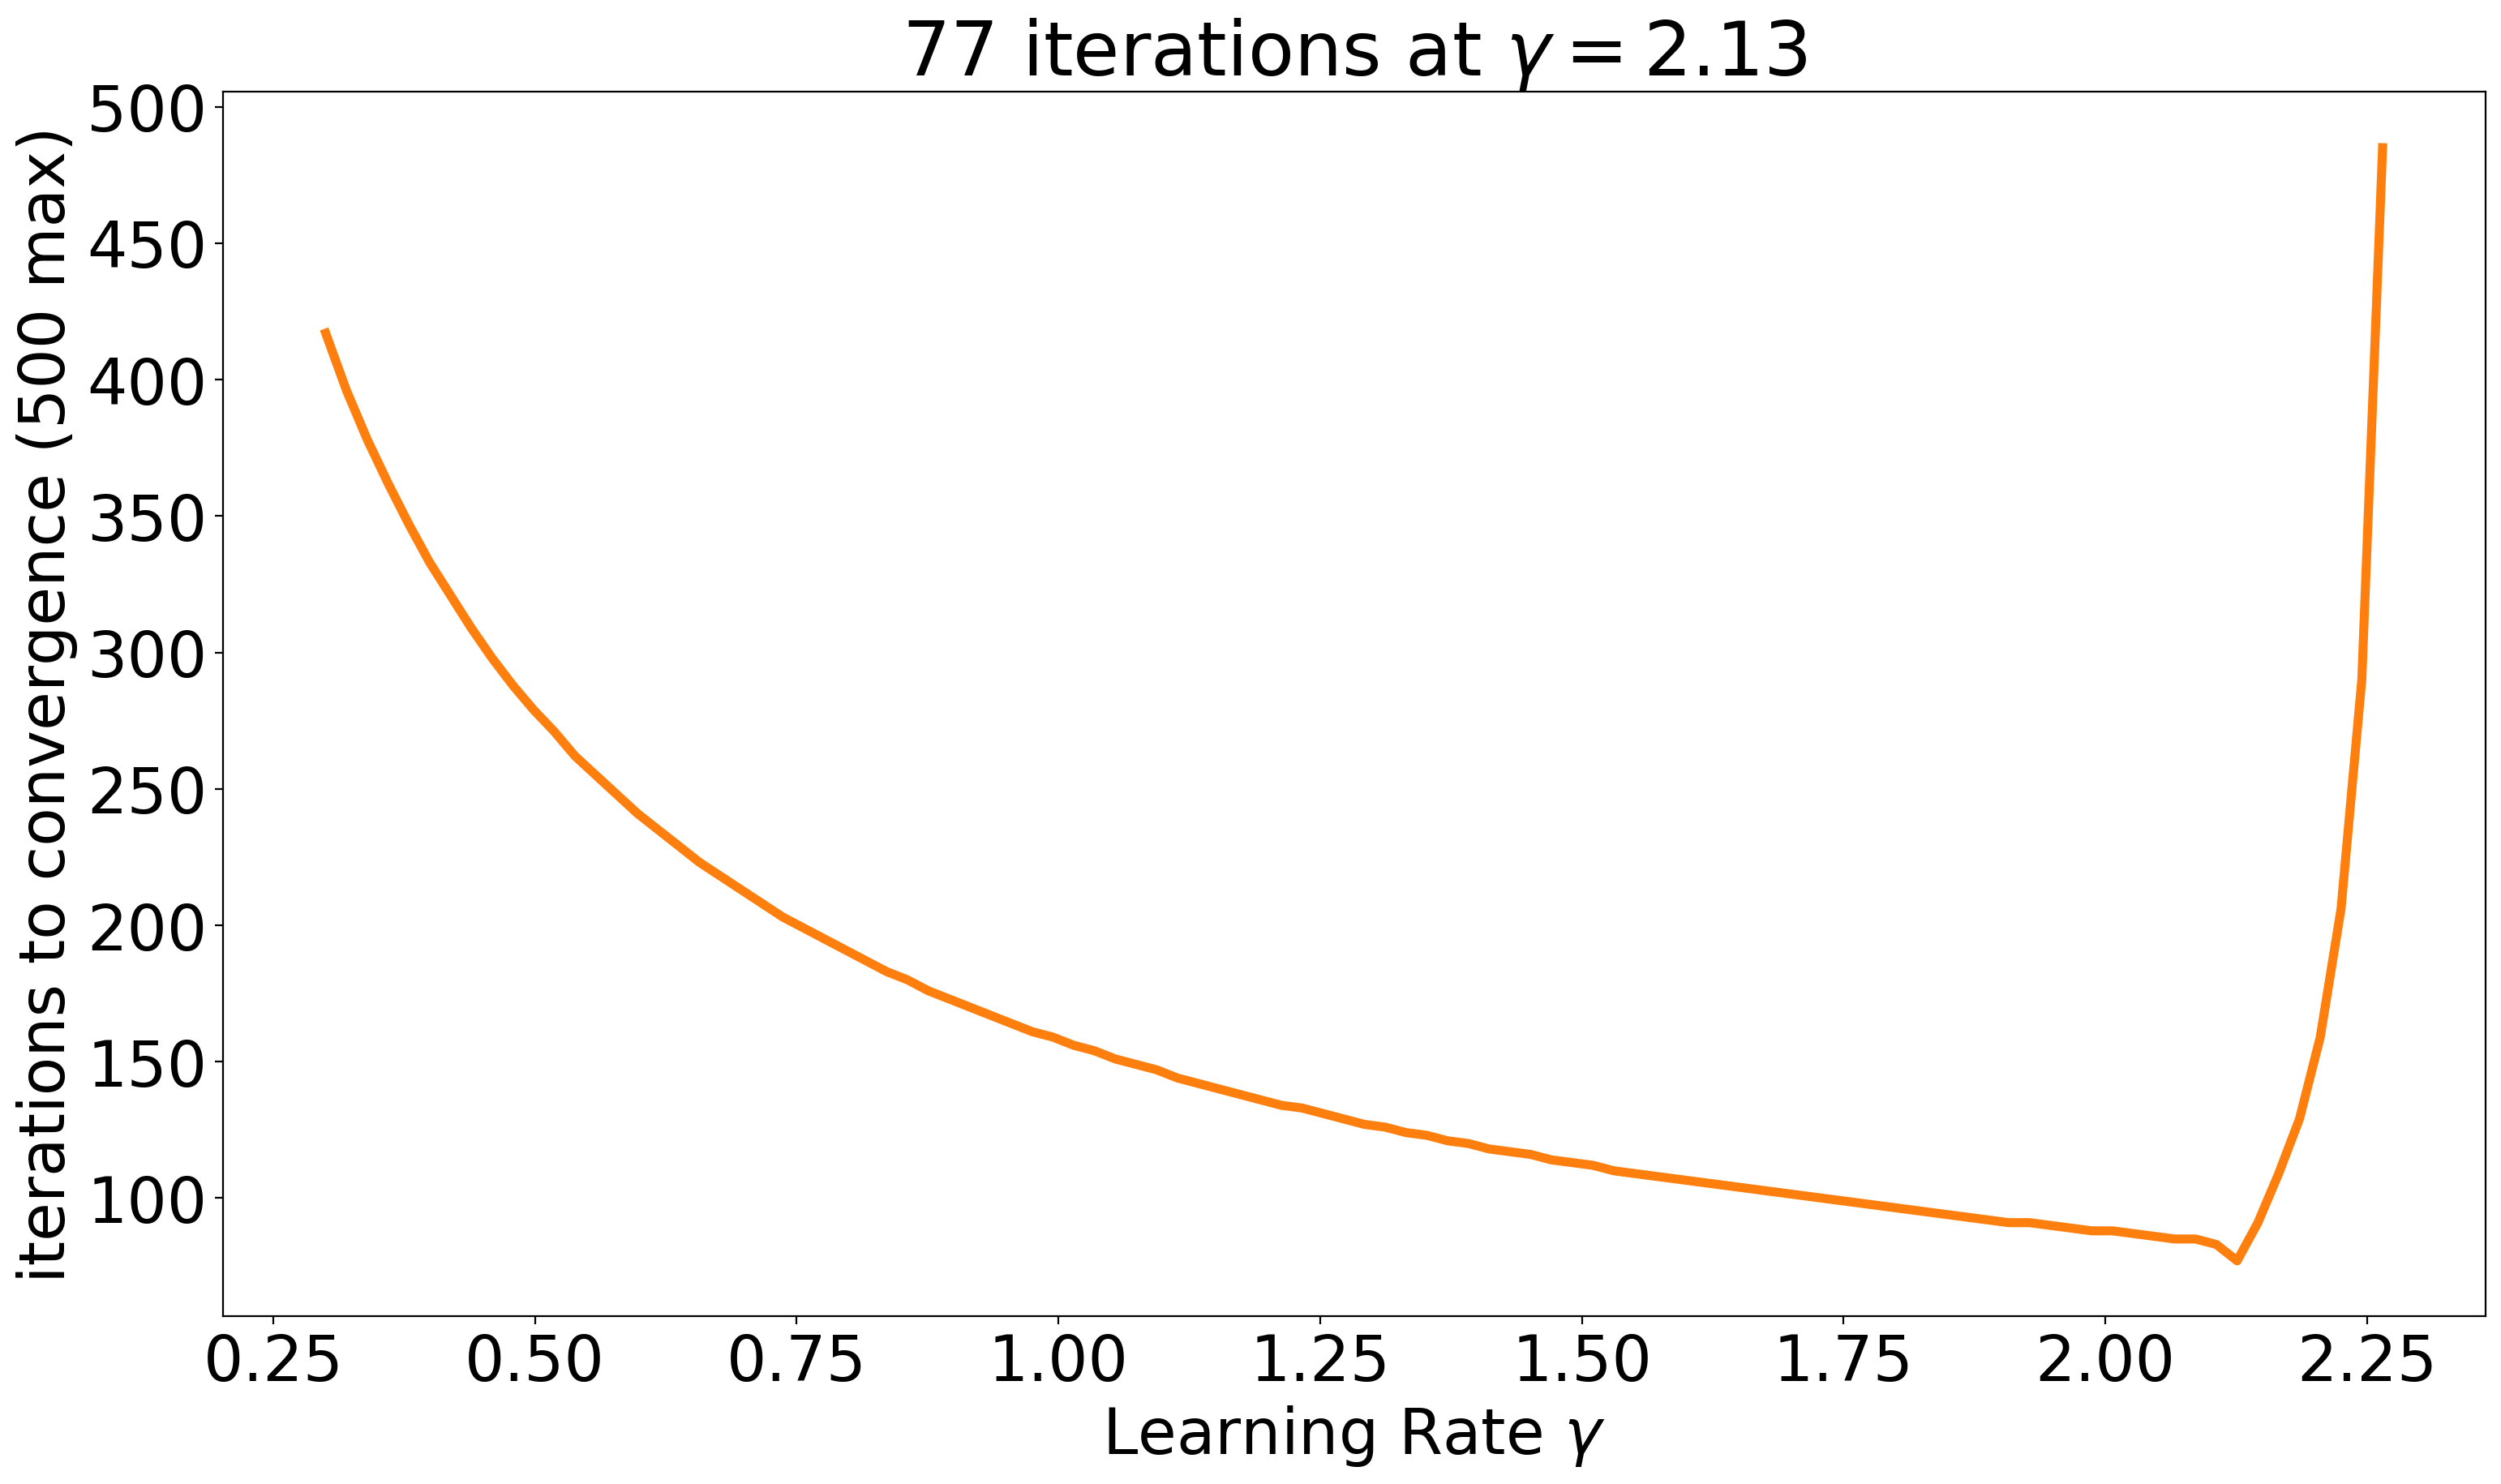

In [40]:
gamma_range = [0.3, 2.265] # kinda hacky, just for a nice plot
pois_bc.plot_learning_rates(theta_init, gamma_range, tol)

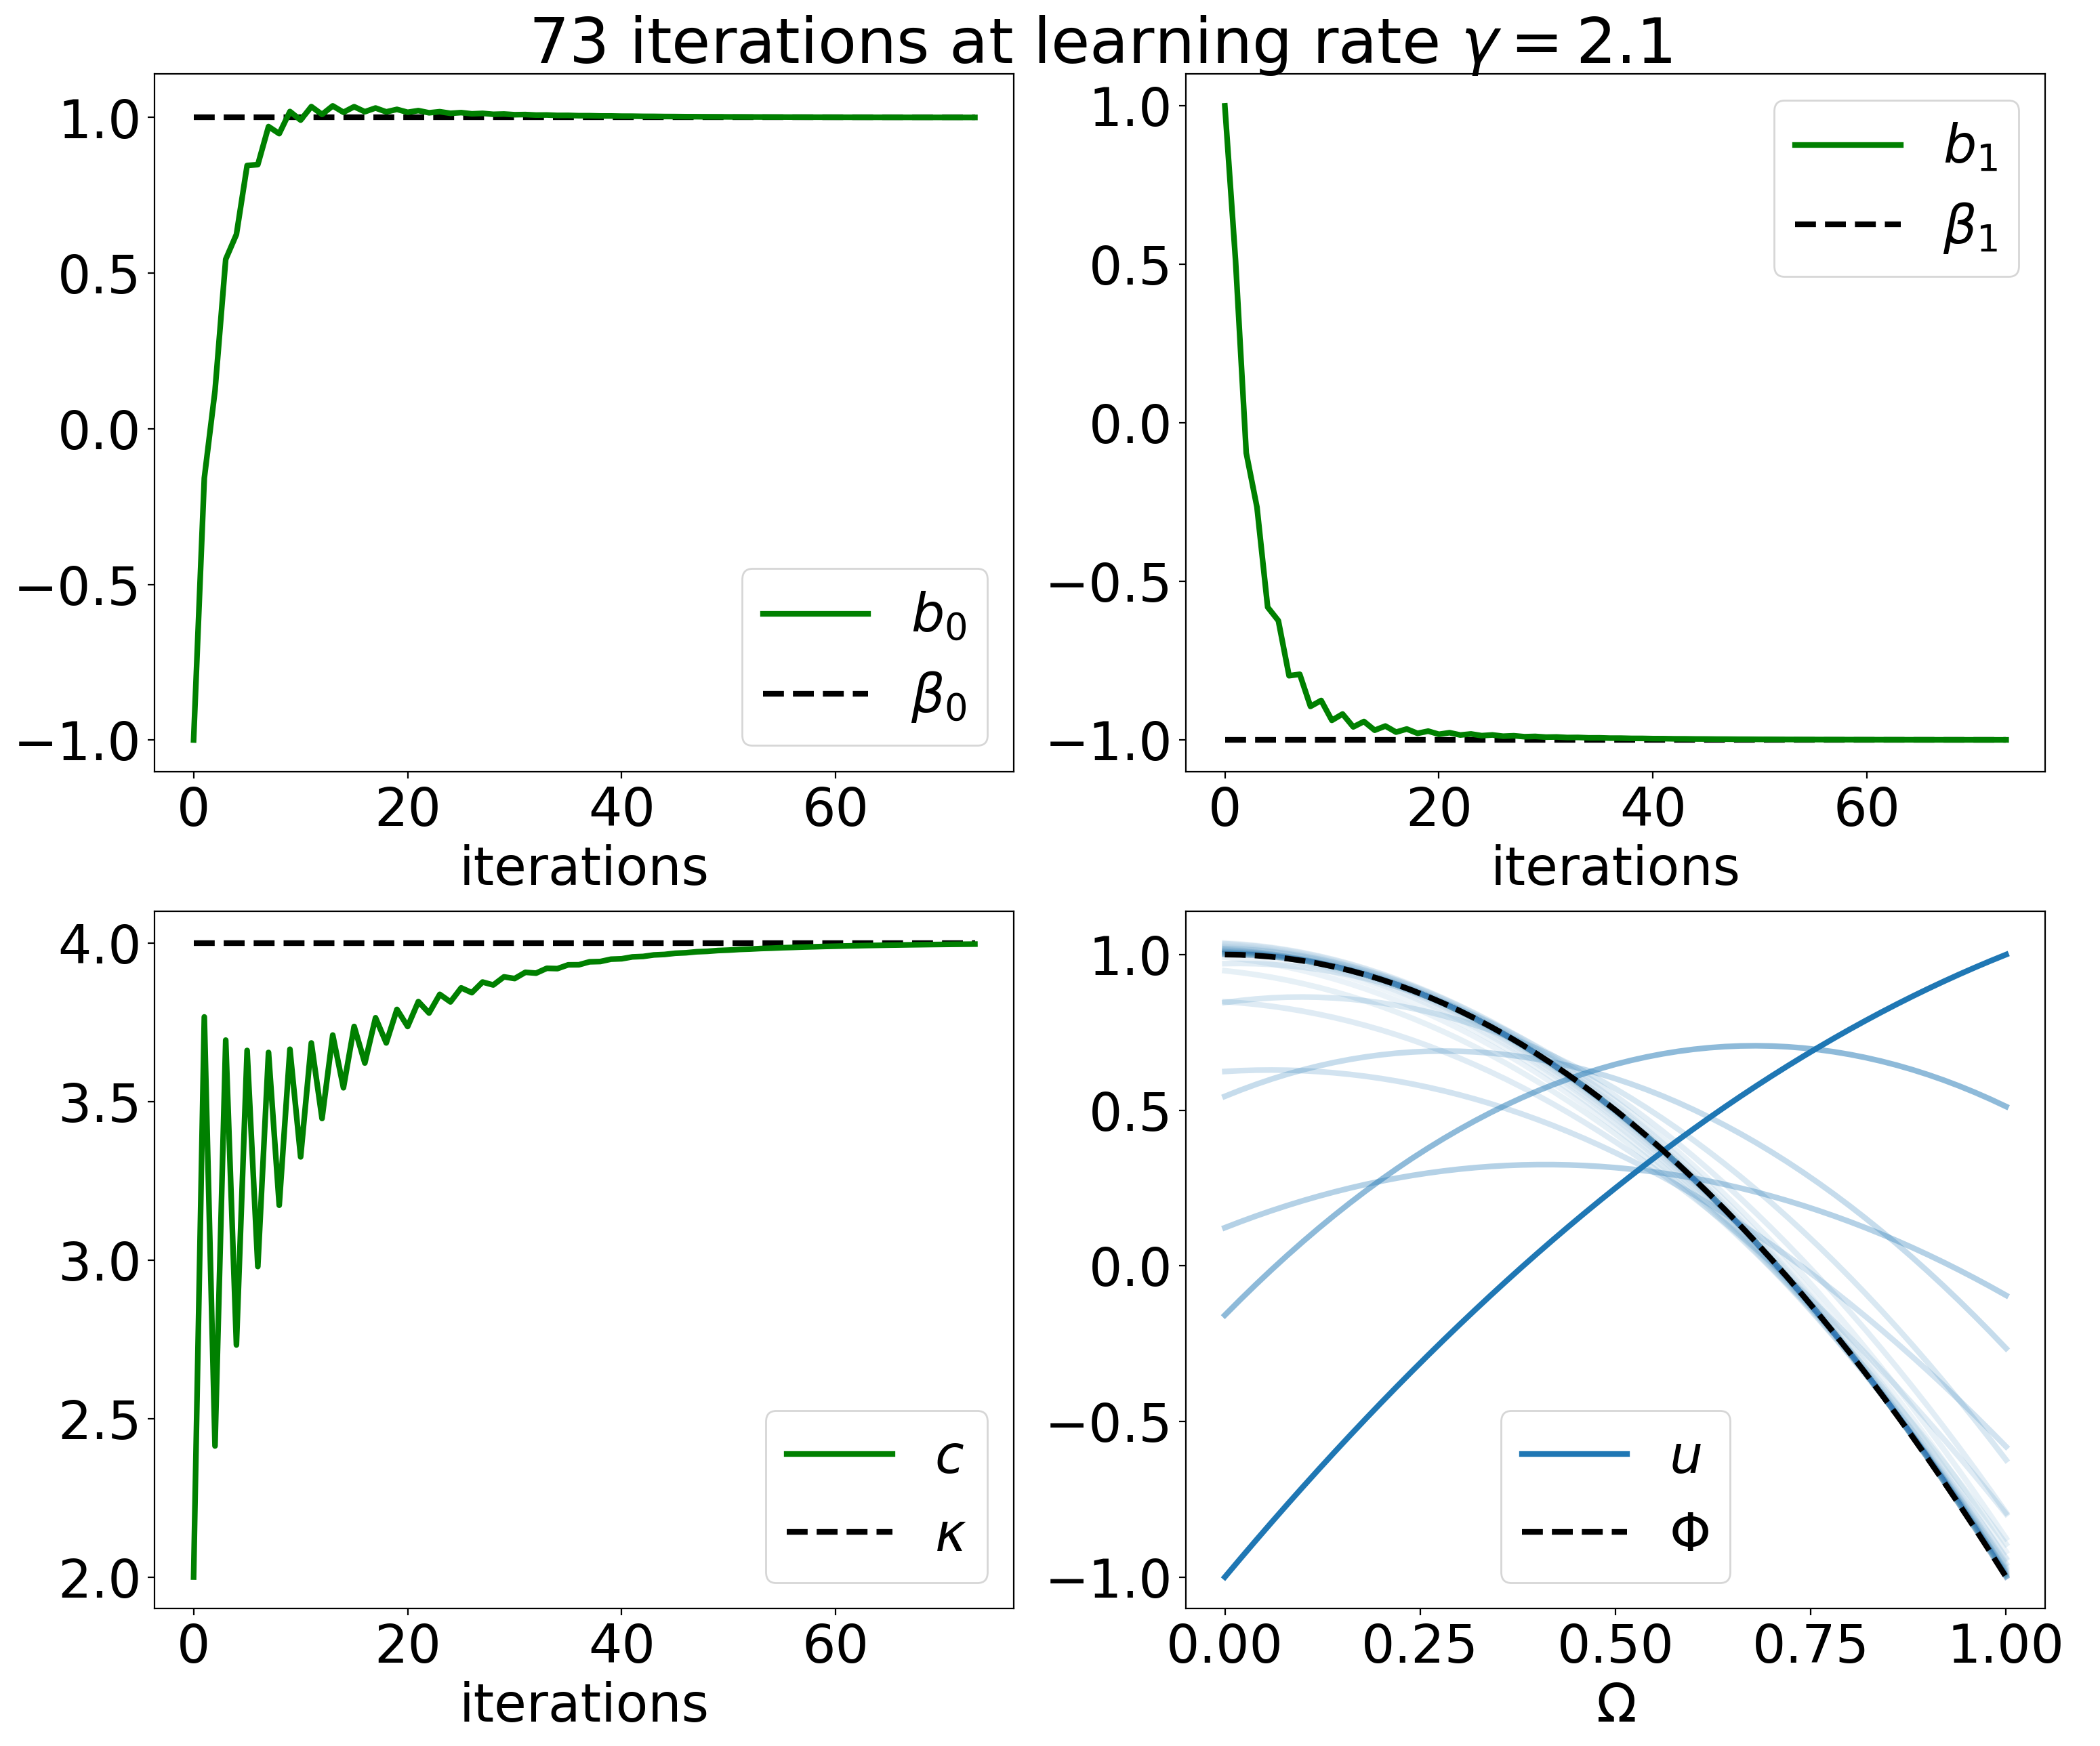

In [41]:
lr_opt = 2.12  # optimal learning rate
pois_bc.descend(theta_init, lr_opt, tol)
pois_bc.plot_grad_descent()

#### Learning with noisy data

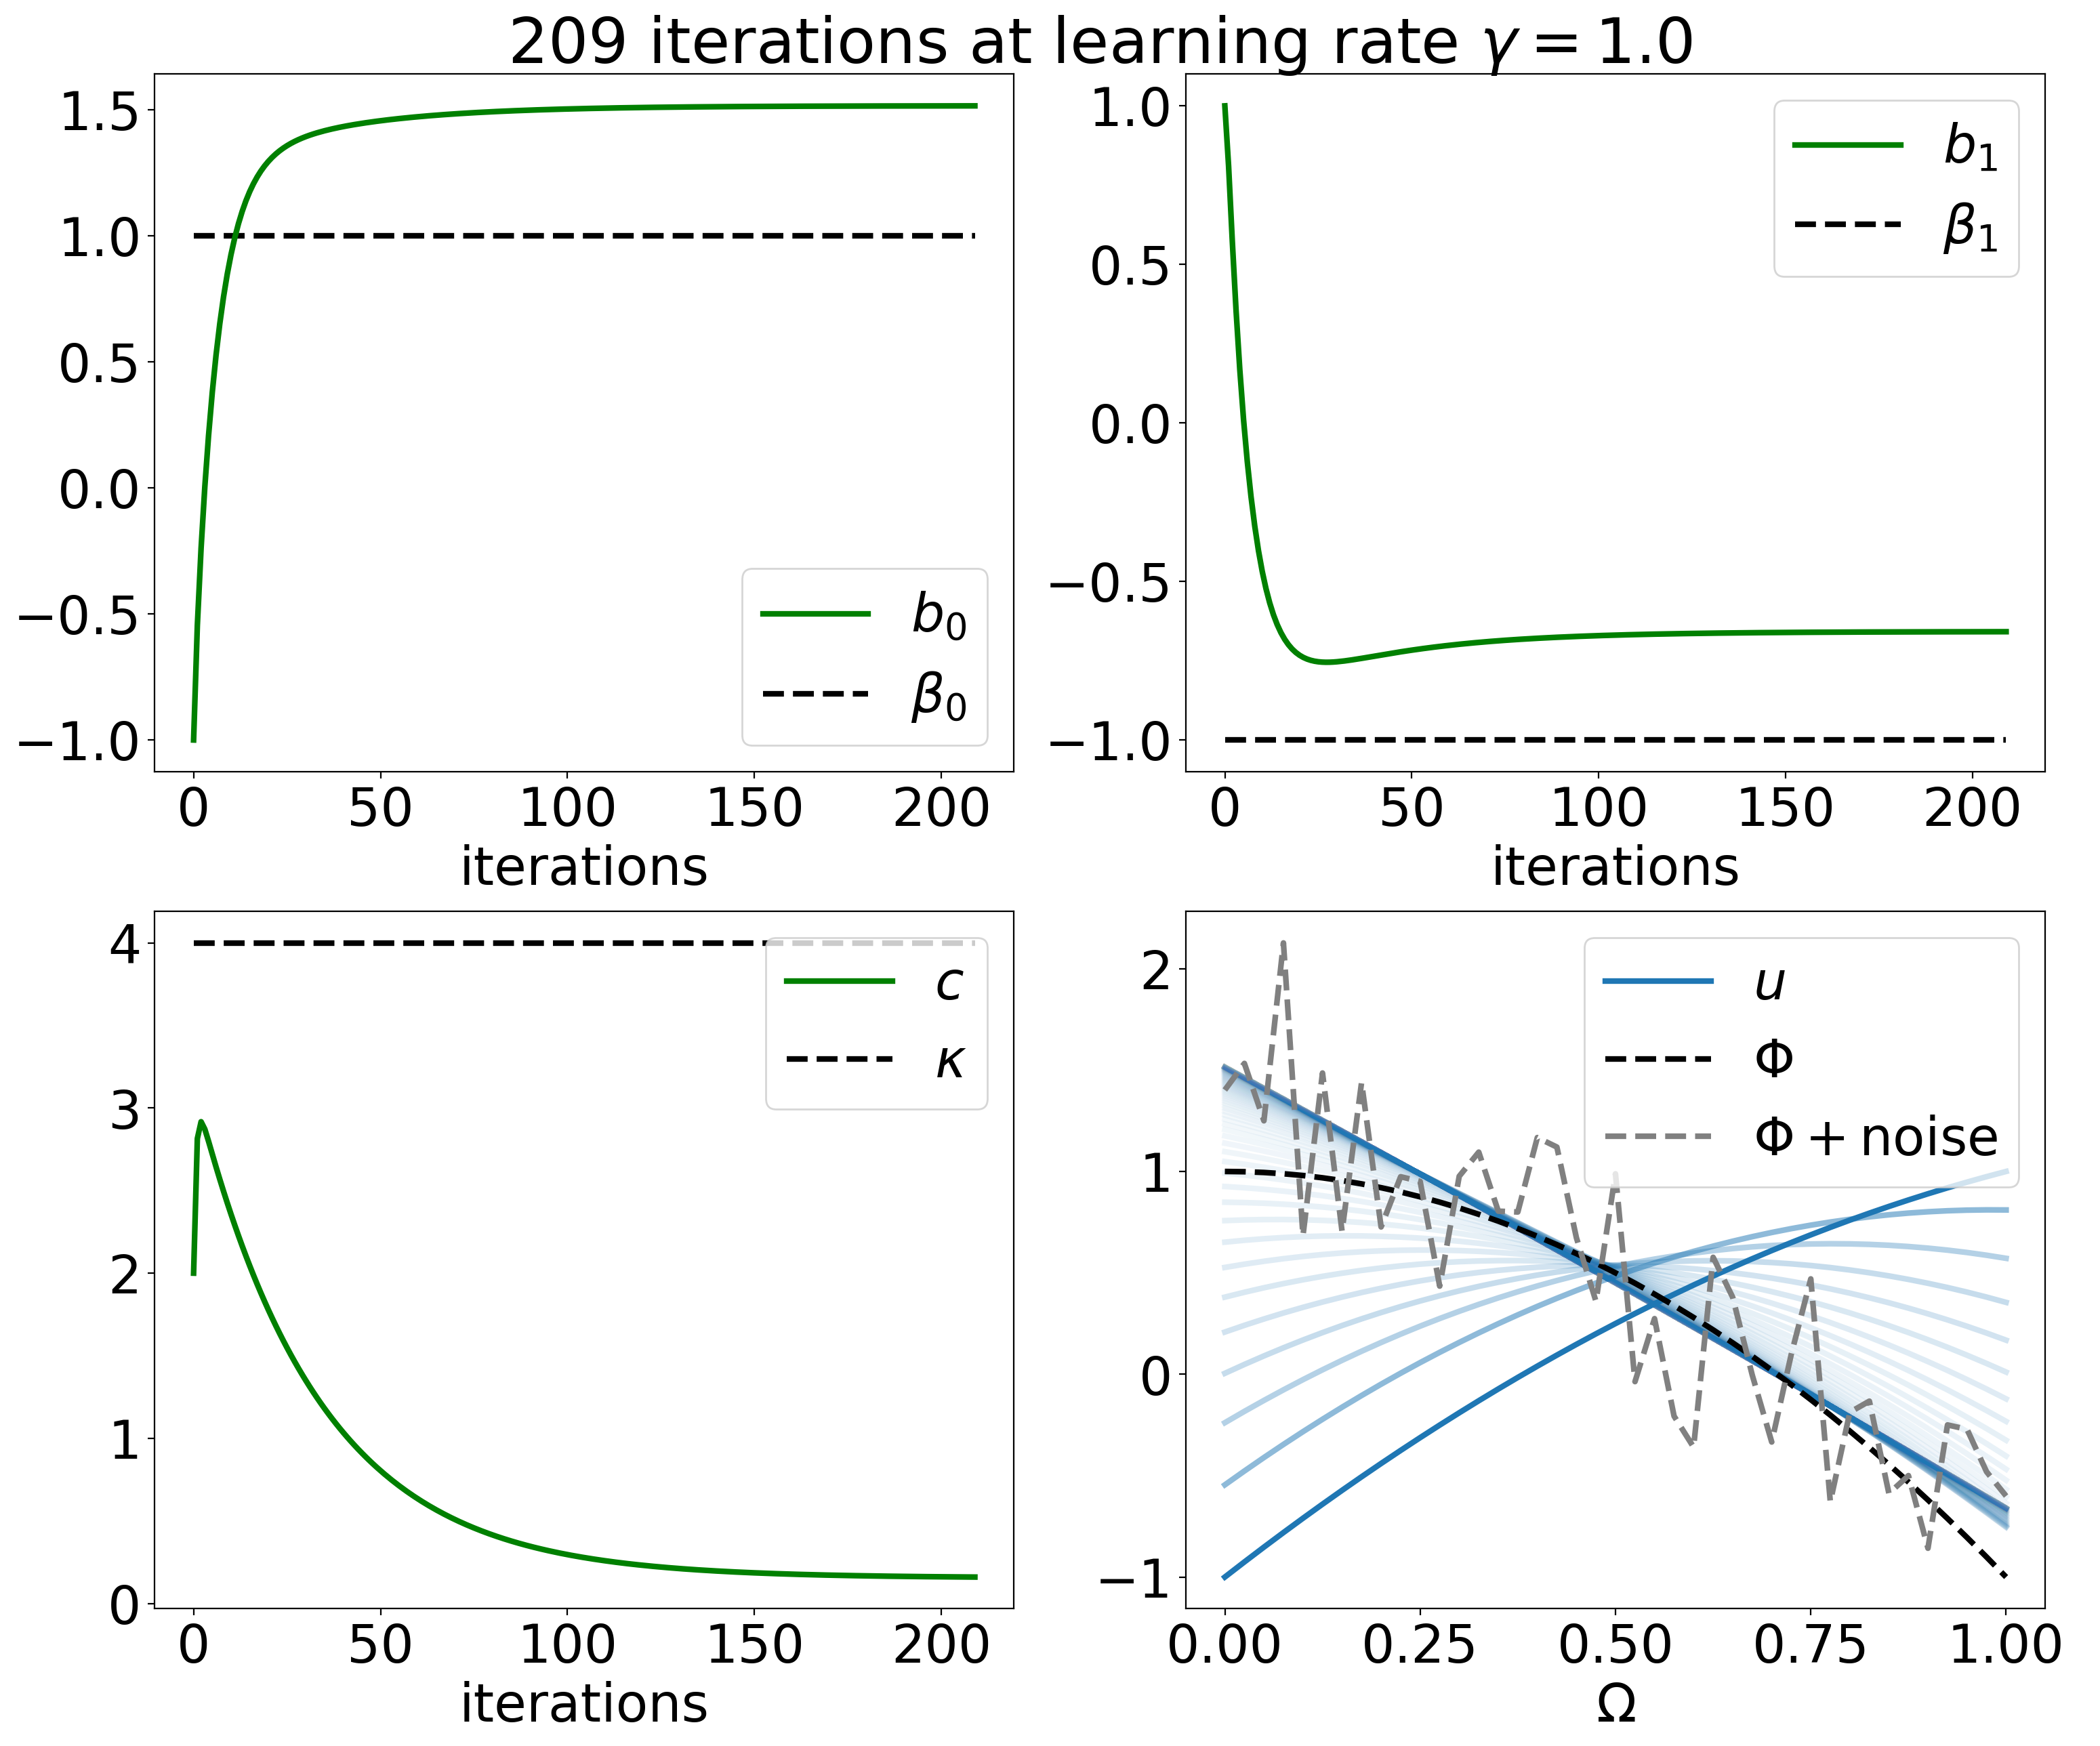

In [43]:
pois_bc_noise = PoissonBC(theta_true, resolution=40, sigma=0.4)
pois_bc_noise.descend(theta_init, lr, tol)
pois_bc_noise.plot_grad_descent()